In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import random


# Tumors in Rats

In [10]:
data1 = pd.read_csv("/Users/brianxiang/Downloads/data.final.2024.Q3.csv")

## Standard MCMC

### Data and Set Up

We are measuring tumor incidence in rats across 15 different experiments. Our data consists of $n_i = $ the number of rats in each experiment $i$ and $y_i = $ the number of those rats that had tumors.

We design a Beta-Binomial hierarchical model as follows:

$$y_i \sim Bin(n_i, \theta_i)$$

$$\theta_i \sim Beta(\alpha, \beta)$$

with noninformative prior $p(\alpha, \beta) \propto 1$.

This gives us the following conditional distributions:

$$\theta_i | y_i, \alpha, \beta \sim Beta(y_i + \alpha, n_i - y_i + \beta)$$

$$p(\alpha, \beta | y, \theta) \propto (\frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha)\Gamma(\beta)})^{15}\prod_{i = 1}^{15}\theta_i^\alpha(1 - \theta_i)^\beta \Rightarrow$$

$$\ln(p(\alpha, \beta | y, \theta)) \propto -15\ln(\frac{\Gamma(\alpha)\Gamma(\beta)}{\Gamma(\alpha + \beta)}) + \sum_{i = 1}^{15} \alpha \ln(\theta_i) + \beta \ln(1 - \theta_i)$$

We use a Gibbs sampler with a Metropolis step to sample from the joint posterior distribution $\theta, \alpha, \beta | y$ using normal proposal distributions $\alpha^* \sim Norm(\alpha^{t - 1}. \nu_\alpha), \beta^* \sim Norm(\beta^{t - 1}. \nu_\beta)$ for each iteration $t$ with tuning parameter $\nu_\alpha, \nu_\beta$.



In [3]:
def logab(theta, a, b):
    if a <= 0 or b <= 0:
        return -float("inf")
    return -15 * np.log(scipy.special.beta(a, b)) + np.sum(a * np.log(theta) + b * np.log(1 - theta))

In [4]:
def chain(n, y, theta_init, alpha_init, beta_init, numsamp, atuning = 0.3, btuning = 1.1):
    accept = 0
    reject = 0
    
    theta_samps = np.zeros((numsamp, 15))
    alpha_samps = np.zeros(numsamp)
    beta_samps = np.zeros(numsamp)
    
    theta_samps[0] = theta_init
    alpha_samps[0] = alpha_init
    beta_samps[0] = beta_init
    
    for i in range(1, numsamp):        
        alpha_prop = np.random.normal(alpha_samps[i - 1], atuning)
        beta_prop = np.random.normal(beta_samps[i - 1], btuning)
        log_r = logab(theta_samps[i - 1], alpha_prop, beta_prop) - logab(theta_samps[i - 1], alpha_samps[i - 1], beta_samps[i - 1])
        log_u = np.log(random.uniform(0, 1))
        
        if log_u <= log_r:
            alpha_samps[i] = alpha_prop
            beta_samps[i] = beta_prop
            accept = accept + 1
            
        else:
            alpha_samps[i] = alpha_samps[i - 1]
            beta_samps[i] = beta_samps[i - 1]
            reject = reject + 1
            
        theta_samps[i] = np.random.beta(y + alpha_samps[i], n - y + beta_samps[i], 15)
        
    print("Acceptance Rate: ", accept/(accept + reject))
    
    return theta_samps, alpha_samps, beta_samps


### Initial Values and Tuning Parameters

We use two chain with inital values:

$$\alpha_1^{(0)} = 1, \beta_1^{(0)} = 2, \theta_{1i}^{(0)} \sim Beta(y_i + 1, n_i - y_i + 2)$$

and 

$$\alpha_2^{(0)} = 20, \beta_2^{(0)} = 50, \theta_{2i}^{(0)} \sim Beta(y_i + 20, n_i - y_i + 50)$$

We use tuning parameters $\nu_\alpha = 0.3, \nu_\beta = 1.1$ which were determined based on the acceptance rate ($\sim$75%).

In [5]:
n = data1['n'].to_numpy()
y = data1['y'].to_numpy()

a_1 = 1
b_1 = 2
theta_1 = np.random.beta(y + a_1, n - y + b_1, 15)

theta_samps1, alpha_samps1, beta_samps1 = chain(n, y, theta_1, a_1, b_1, 10000)

a_2 = 20
b_2 = 50
theta_2 = np.random.beta(y + a_2, n - y + b_2, 15)

theta_samps2, alpha_samps2, beta_samps2 = chain(n, y, theta_2, a_2, b_2, 10000)

Acceptance Rate:  0.7506750675067507
Acceptance Rate:  0.7612761276127613


In [6]:
chain1_df = pd.DataFrame(np.vstack((np.linspace(1, 10000, 10000), alpha_samps1, beta_samps1, theta_samps1.T)).T, columns = ('iteration', 'alpha', 'beta', 'theta_1', 'theta_2', 'theta_3', 'theta_4', 'theta_5', 'theta_6', 'theta_7', 'theta_8', 'theta_9', 'theta_10', 'theta_11', 'theta_12', 'theta_13', 'theta_14', 'theta_15'))
chain2_df = pd.DataFrame(np.vstack((np.linspace(1, 10000, 10000), alpha_samps2, beta_samps2, theta_samps2.T)).T, columns = ('iteration', 'alpha', 'beta', 'theta_1', 'theta_2', 'theta_3', 'theta_4', 'theta_5', 'theta_6', 'theta_7', 'theta_8', 'theta_9', 'theta_10', 'theta_11', 'theta_12', 'theta_13', 'theta_14', 'theta_15'))

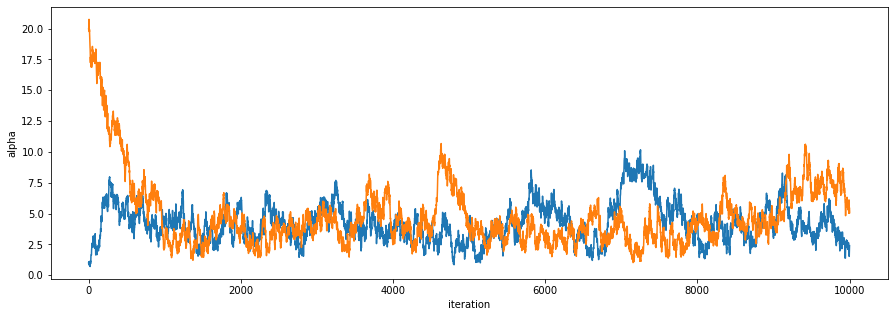

In [7]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'alpha', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'alpha', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

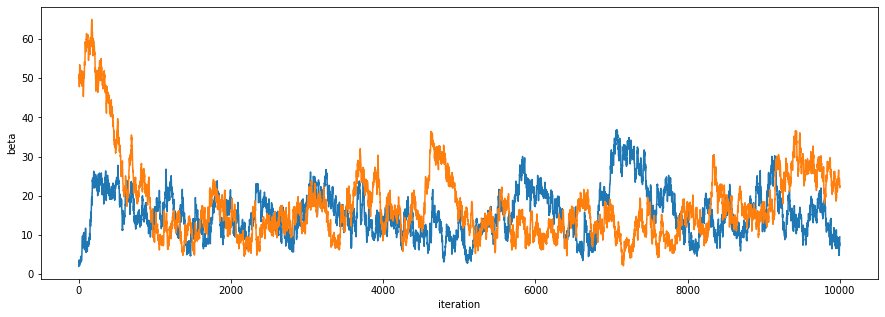

In [8]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'beta', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'beta', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

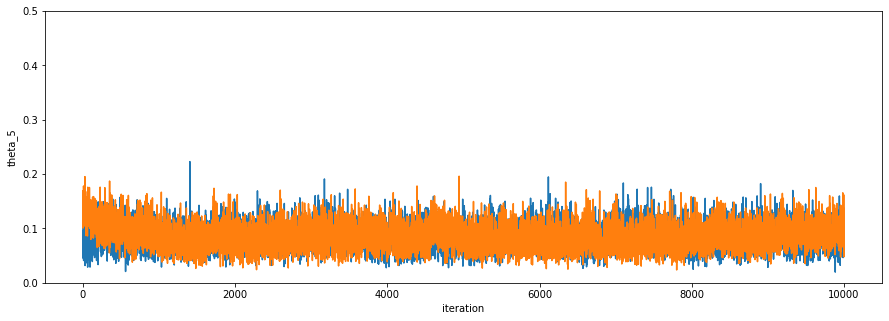

In [9]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'theta_5', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'theta_5', ax = ax)

ax.set_ylim(0, 0.5)
plt.show()

## Unbiased MCMC

In [18]:
def ar(prev, prop, crit, log_pdf):
    log_r = log_pdf(prop) - log_pdf(prev)
    if crit <= log_r:
        return prop
    else:
        return prev

In [19]:
def sample_couple(prev_x, prev_y, tuning):
    log_p = lambda z: scipy.stats.multivariate_normal.logpdf(z, prev_x, tuning * np.ones(len(prev_x)))
    log_q = lambda z: scipy.stats.multivariate_normal.logpdf(z, prev_y, tuning * np.ones(len(prev_y)))
    
    x_prop = np.array([scipy.stats.multivariate_normal.rvs(prev_x, tuning * np.ones(len(prev_x)))]).ravel()
    
    if np.log(random.uniform(0, 1)) <= log_q(x_prop) - log_p(x_prop):
        return x_prop, x_prop
    else:
        y_prop = np.array([scipy.stats.multivariate_normal.rvs(prev_y, tuning * np.ones(len(prev_y)))]).ravel()
        while np.log(random.uniform(0, 1)) <= log_p(y_prop) - log_q(y_prop):
            y_prop = np.array([scipy.stats.multivariate_normal.rvs(prev_y, tuning * np.ones(len(prev_y)))]).ravel()
            
        return x_prop, y_prop


In [12]:
def loga(alpha, beta, theta):
    if alpha <= 0:
        return -float("inf")
    return 15 * (np.log(scipy.special.gamma(alpha + beta)) - np.log(scipy.special.gamma(alpha))) + alpha * np.sum(np.log(theta))

In [13]:
def logb(alpha, beta, theta):
    if beta <= 0:
        return -float("inf")
    return 15 * (np.log(scipy.special.gamma(alpha + beta)) - np.log(scipy.special.gamma(beta))) + beta * np.sum(np.log(1 - theta))

In [14]:
def unbiased_rat_metropolis(n, y, theta_init1, alpha_init1, beta_init1, theta_init2, alpha_init2, beta_init2, numsamp, atuning = 0.3, btuning = 1.1, lag = 1):
    theta_samps1 = np.zeros((numsamp, 15))
    alpha_samps1 = np.zeros(numsamp)
    beta_samps1 = np.zeros(numsamp)
    
    theta_samps2 = np.zeros((numsamp - lag, 15))
    alpha_samps2 = np.zeros(numsamp - lag)
    beta_samps2 = np.zeros(numsamp - lag)
    
    theta_samps1[0] = theta_init1
    alpha_samps1[0] = alpha_init1
    beta_samps1[0] = beta_init1
    
    theta_samps2[0] = theta_init2
    alpha_samps2[0] = alpha_init2
    beta_samps2[0] = beta_init2
    
    cnta = 0
    cntb = 0
    cnttheta = np.zeros(15)
    
    converge = False
        
    for i in range(1, numsamp):
        if i <= lag:
            alpha_prop1 = np.random.normal(alpha_samps1[i - 1], atuning)
            logu = np.log(random.uniform(0, 1))
            alpha_samps1[i] = ar(alpha_samps1[i - 1], alpha_prop1, logu, lambda z: loga(z, beta_samps1[i - 1], theta_samps1[i - 1]))

            beta_prop1 = np.random.normal(beta_samps1[i - 1], btuning)
            logu = np.log(random.uniform(0, 1))
            beta_samps1[i] = ar(beta_samps1[i - 1], beta_prop1, logu, lambda z: logb(alpha_samps1[i], z, theta_samps1[i - 1]))

            theta_samps1[i] = np.random.beta(y + alpha_samps1[i], n - y + beta_samps1[i], 15)

        else:
            alpha_prop1, alpha_prop2 = sample_couple(np.array([alpha_samps1[i - 1]]), np.array([alpha_samps2[i - lag - 1]]), atuning)
            logu = np.log(random.uniform(0, 1))
            alpha_samps1[i] = ar(alpha_samps1[i - 1], alpha_prop1, logu, lambda z: loga(z, beta_samps1[i - 1], theta_samps1[i - 1]))
            alpha_samps2[i - lag] = ar(alpha_samps2[i - lag - 1], alpha_prop2, logu, lambda z: loga(z, beta_samps2[i - lag - 1], theta_samps2[i - lag - 1]))

            beta_prop1, beta_prop2 = sample_couple(np.array([beta_samps1[i - 1]]), np.array([beta_samps2[i - lag - 1]]), btuning)
            logu = np.log(random.uniform(0, 1))
            beta_samps1[i] = ar(beta_samps1[i - 1], beta_prop1, logu, lambda z: logb(alpha_samps1[i], z, theta_samps1[i - 1]))
            beta_samps2[i - lag] = ar(beta_samps2[i - lag - 1], beta_prop2, logu, lambda z: logb(alpha_samps2[i - lag], z, theta_samps2[i - lag - 1]))

            theta_samps1[i] = np.random.beta(y + alpha_samps1[i], n - y + beta_samps1[i], 15)
            theta_samps2[i - lag] = np.random.beta(y + alpha_samps2[i - lag], n - y + beta_samps2[i - lag], 15)

        if alpha_samps1[i] == alpha_samps2[i - lag] and beta_samps1[i] == beta_samps2[i - lag]:
            if not converge:
                print(i)
                converge = True
    if not converge:
        print("did not converge")
        
    return theta_samps1, alpha_samps1, beta_samps1, theta_samps2, alpha_samps2, beta_samps2


In [15]:
n = data1['n'].to_numpy()
y = data1['y'].to_numpy()

a_1 = 1
b_1 = 2
theta_1 = np.random.beta(y + a_1, n - y + b_1, 15)

a_2 = 20
b_2 = 50
theta_2 = np.random.beta(y + a_2, n - y + b_2, 15)

theta_samps1, alpha_samps1, beta_samps1, theta_samps2, alpha_samps2, beta_samps2 = unbiased_rat_metropolis(n, y, theta_1, a_1, b_1, theta_2, a_2, b_2, 15000)

874


In [16]:
chain1_df = pd.DataFrame(np.vstack((np.linspace(1, 10000, 10000), alpha_samps1[1:10001], beta_samps1[1:10001], theta_samps1[1:10001].T)).T, columns = ('iteration', 'alpha', 'beta', 'theta_1', 'theta_2', 'theta_3', 'theta_4', 'theta_5', 'theta_6', 'theta_7', 'theta_8', 'theta_9', 'theta_10', 'theta_11', 'theta_12', 'theta_13', 'theta_14', 'theta_15'))
chain2_df = pd.DataFrame(np.vstack((np.linspace(1, 10000, 10000), alpha_samps2[:10000], beta_samps2[:10000], theta_samps2[:10000].T)).T, columns = ('iteration', 'alpha', 'beta', 'theta_1', 'theta_2', 'theta_3', 'theta_4', 'theta_5', 'theta_6', 'theta_7', 'theta_8', 'theta_9', 'theta_10', 'theta_11', 'theta_12', 'theta_13', 'theta_14', 'theta_15'))

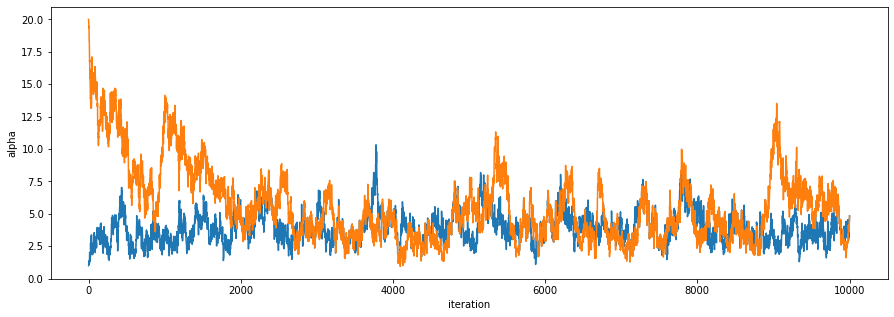

In [17]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'alpha', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'alpha', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

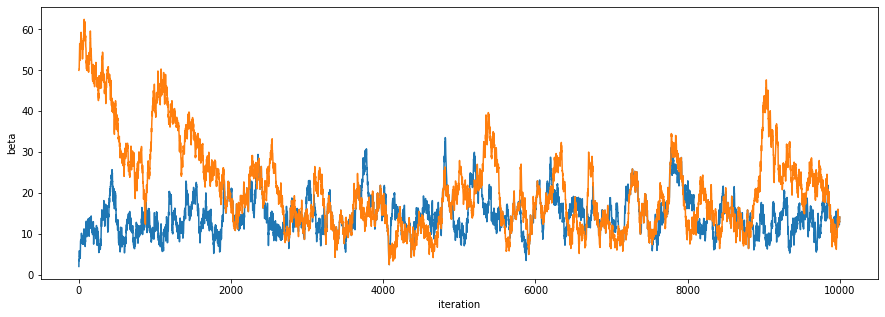

In [18]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'beta', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'beta', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

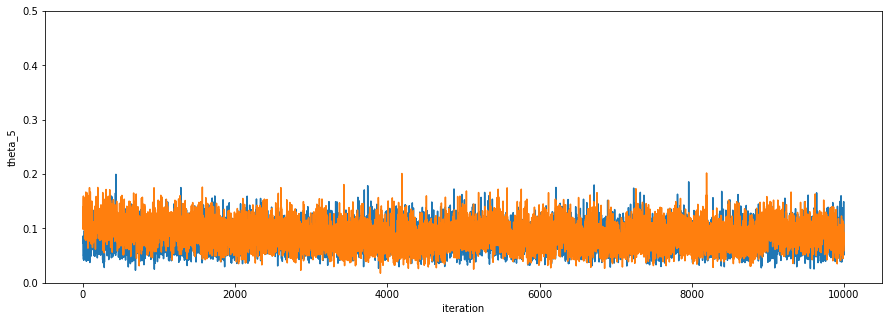

In [19]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'theta_5', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'theta_5', ax = ax)

ax.set_ylim(0, 0.5)
plt.show()

# Total Traffic Data

In [163]:
data2 = pd.read_table("/Users/brianxiang/Downloads/bicycles-1.txt", sep = '\s+', header = 0)

Determine the amount of traffic on each street.

$$y_i \sim Poisson(\theta_i)$$
$$\theta_i \sim Gamma(\alpha, \beta)$$
$$p(\alpha, \beta) \propto 1$$

Poisson-Gamma HM

## Standard

In [1036]:
y = data2.iloc[2, 2:12].astype(int).to_numpy() + data2.iloc[2, 12:22].astype(int).to_numpy()

In [1037]:
def loga(y, alpha, beta, theta):
    if alpha <= 0:
        return -float("inf")
    else:
        n = len(y)
        return alpha * n * np.log(beta) - n * scipy.special.gammaln(alpha) + alpha * np.sum(np.log(theta))
        

In [1038]:
def standard_mh(y, alpha_init1, beta_init1, theta_init1, alpha_init2, beta_init2, theta_init2, tuning, numsamp):
    alpha_samps1 = np.zeros(numsamp)
    beta_samps1 = np.zeros(numsamp)
    theta_samps1 = np.zeros((numsamp, len(y)))
    
    alpha_samps1[0] = alpha_init1
    beta_samps1[0] = beta_init1
    theta_samps1[0] = theta_init1
    
    alpha_samps2 = np.zeros(numsamp)
    beta_samps2 = np.zeros(numsamp)
    theta_samps2 = np.zeros((numsamp, len(y)))
    
    alpha_samps2[0] = alpha_init2
    beta_samps2[0] = beta_init2
    theta_samps2[0] = theta_init2
    
    for i in range(1, numsamp):
        theta_prop1 = np.random.gamma(alpha_samps1[i - 1] + y, scale = 1 / (beta_samps1[i - 1] + 1), size = len(y))
        theta_samps1[i] = theta_prop1
        
        beta_prop1 = np.random.gamma(alpha_samps1[i - 1] * len(y) + 1, scale = 1 / (np.sum(theta_samps1[i])))
        beta_samps1[i] = beta_prop1
    
        alpha_prop1 = np.random.normal(alpha_samps1[i - 1], tuning)
        logu = np.log(random.uniform(0, 1))
        alpha_samps1[i] = ar(alpha_samps1[i - 1], alpha_prop1, logu, lambda x: loga(y, x, beta_samps1[i], theta_samps1[i]))[0]
        
        theta_prop2 = np.random.gamma(alpha_samps2[i - 1] + y, scale = 1 / (beta_samps2[i - 1] + 1), size = len(y))
        theta_samps2[i] = theta_prop2
        
        beta_prop2 = np.random.gamma(alpha_samps2[i - 1] * len(y) + 1, scale = 1 / (np.sum(theta_samps2[i])))
        beta_samps2[i] = beta_prop2
    
        alpha_prop2 = np.random.normal(alpha_samps2[i - 1], tuning)
        logu = np.log(random.uniform(0, 1))
        alpha_samps2[i] = ar(alpha_samps2[i - 1], alpha_prop2, logu, lambda x: loga(y, x, beta_samps2[i], theta_samps2[i]))[0]
        
    return alpha_samps1, beta_samps1, theta_samps1, alpha_samps2, beta_samps2, theta_samps2

In [1039]:
alpha_init1 = 50
beta_init1 = 20
theta_init1 = np.random.gamma(50 + y, 21, len(y))

alpha_init2 = 15
beta_init2 = 30
theta_init2 = np.random.gamma(15 + y, 31, len(y))

alpha_samps1, beta_samps1, theta_samps1, alpha_samps2, beta_samps2, theta_samps2 = standard_mh(y, alpha_init1, beta_init1, theta_init1, alpha_init2, beta_init2, theta_init2, tuning = 0.25, numsamp = 15000)

In [1040]:
chain1_df = pd.DataFrame(np.vstack((np.linspace(1, 14000, 14000), alpha_samps1[1:14001], beta_samps1[1:14001], theta_samps1[1:14001].T)).T, columns = ('iteration', 'alpha', 'beta', 'theta_1', 'theta_2', 'theta_3', 'theta_4', 'theta_5', 'theta_6', 'theta_7', 'theta_8', 'theta_9', 'theta_10'))
chain2_df = pd.DataFrame(np.vstack((np.linspace(1, 14000, 14000), alpha_samps2[:14000], beta_samps2[:14000], theta_samps2[:14000].T)).T, columns = ('iteration', 'alpha', 'beta', 'theta_1', 'theta_2', 'theta_3', 'theta_4', 'theta_5', 'theta_6', 'theta_7', 'theta_8', 'theta_9', 'theta_10'))

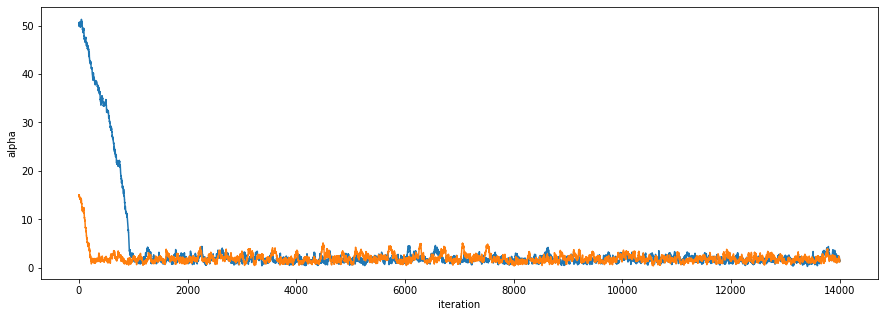

In [1041]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'alpha', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'alpha', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

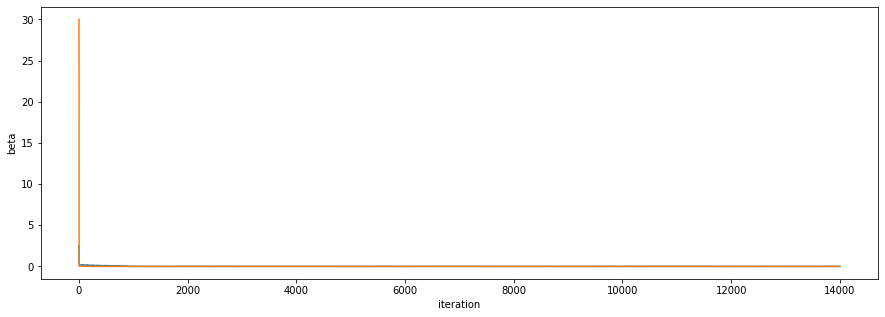

In [1042]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'beta', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'beta', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

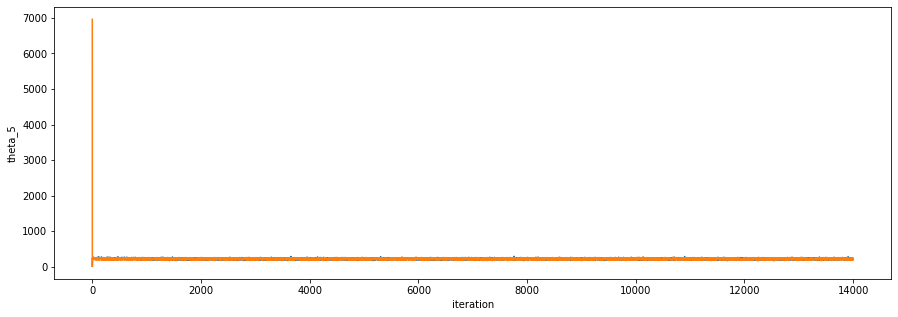

In [1043]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'theta_5', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'theta_5', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

## Unbiased

In [66]:
def unbiased_mh(y, alpha_init1, beta_init1, theta_init1, alpha_init2, beta_init2, theta_init2, tuning, numsamp, lag = 1):
    alpha_samps1 = np.zeros(numsamp)
    beta_samps1 = np.zeros(numsamp)
    theta_samps1 = np.zeros((numsamp, len(y)))
    
    alpha_samps1[0] = alpha_init1
    beta_samps1[0] = beta_init1
    theta_samps1[0] = theta_init1
    
    alpha_samps2 = np.zeros(numsamp - lag)
    beta_samps2 = np.zeros(numsamp - lag)
    theta_samps2 = np.zeros((numsamp - lag, len(y)))
    
    alpha_samps2[0] = alpha_init2
    beta_samps2[0] = beta_init2
    theta_samps2[0] = theta_init2
    
    alpha_cnt = 0
    beta_cnt = 0
    theta_cnt = np.zeros(len(y))
    
    converge = False
    
    for i in range(1, numsamp):
        if lag >= i:
            theta_samps1[i] = np.random.gamma(alpha_samps1[i - 1] + y, scale = 1 / (beta_samps1[i - 1] + 1), size = len(y))
            beta_samps1[i] = np.random.gamma(alpha_samps1[i - 1] * len(y) + 1, scale = 1 / (np.sum(theta_samps1[i])))

            alpha_prop1 = np.random.normal(alpha_samps1[i - 1], tuning)
            logu = np.log(random.uniform(0, 1))
            alpha_samps1[i] = ar(alpha_samps1[i - 1], alpha_prop1, logu, lambda x: loga(y, x, beta_samps1[i], theta_samps1[i]))
            
        if lag < i:
            theta_samps1[i] = np.random.gamma(alpha_samps1[i - 1] + y, scale = 1 / (beta_samps1[i - 1] + 1), size = len(y))
            theta_samps2[i - lag] = np.random.gamma(alpha_samps2[i - lag - 1] + y, scale = 1 / (beta_samps2[i - lag - 1] + 1), size = len(y))

            beta_samps1[i] = np.random.gamma(alpha_samps1[i - 1] * len(y) + 1, scale = 1 / (np.sum(theta_samps1[i])))
            beta_samps2[i - lag] = np.random.gamma(alpha_samps2[i - lag - 1] * len(y) + 1, scale = 1 / (np.sum(theta_samps2[i - lag])))

            alpha_prop1, alpha_prop2 = sample_couple(np.array([alpha_samps1[i - 1]]), np.array([alpha_samps2[i - lag - 1]]), tuning)
            logu = np.log(random.uniform(0, 1))
            alpha_samps1[i] = ar(alpha_samps1[i - 1], alpha_prop1, logu, lambda x: loga(y, x, beta_samps1[i], theta_samps1[i]))
            alpha_samps2[i - lag] = ar(alpha_samps2[i - lag - 1], alpha_prop2, logu, lambda x: loga(y, x, beta_samps2[i - lag], theta_samps2[i - lag]))

        if alpha_samps1[i] == alpha_samps2[i - lag] and beta_samps1[i] == beta_samps2[i - lag]:
            if not converge:
                print(i)
                converge = True
    if not converge:
        print("Did not converge")
        
    return alpha_samps1, beta_samps1, theta_samps1, alpha_samps2, beta_samps2, theta_samps2

In [67]:
alpha_init1 = 50
beta_init1 = 20
theta_init1 = np.random.gamma(50 + y, 21, len(y))

alpha_init2 = 15
beta_init2 = 30
theta_init2 = np.random.gamma(15 + y, 31, len(y))

alpha_samps1, beta_samps1, theta_samps1, alpha_samps2, beta_samps2, theta_samps2 = unbiased_mh(y, alpha_init1, beta_init1, theta_init1, alpha_init2, beta_init2, theta_init2, tuning = 0.25, numsamp = 15000)

Did not converge


In [68]:
chain1_df = pd.DataFrame(np.vstack((np.linspace(1, 10000, 10000), alpha_samps1[1:10001], beta_samps1[1:10001], theta_samps1[1:10001].T)).T, columns = ('iteration', 'alpha', 'beta', 'theta_1', 'theta_2', 'theta_3', 'theta_4', 'theta_5', 'theta_6', 'theta_7', 'theta_8', 'theta_9', 'theta_10'))
chain2_df = pd.DataFrame(np.vstack((np.linspace(1, 10000, 10000), alpha_samps2[:10000], beta_samps2[:10000], theta_samps2[:10000].T)).T, columns = ('iteration', 'alpha', 'beta', 'theta_1', 'theta_2', 'theta_3', 'theta_4', 'theta_5', 'theta_6', 'theta_7', 'theta_8', 'theta_9', 'theta_10'))

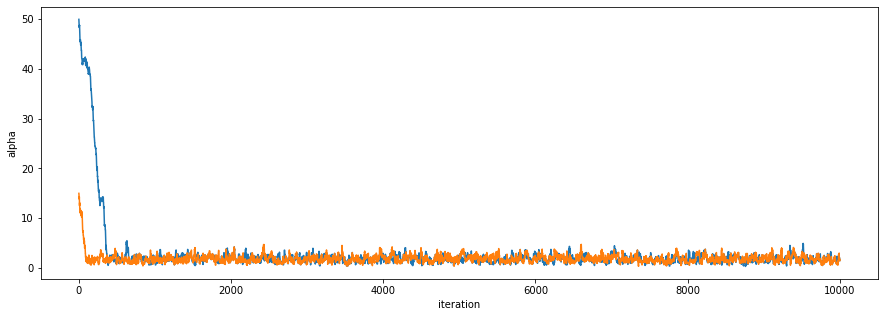

In [69]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'alpha', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'alpha', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

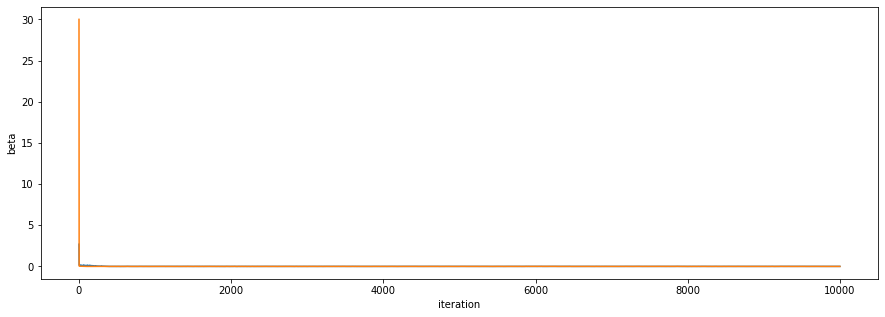

In [70]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'beta', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'beta', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

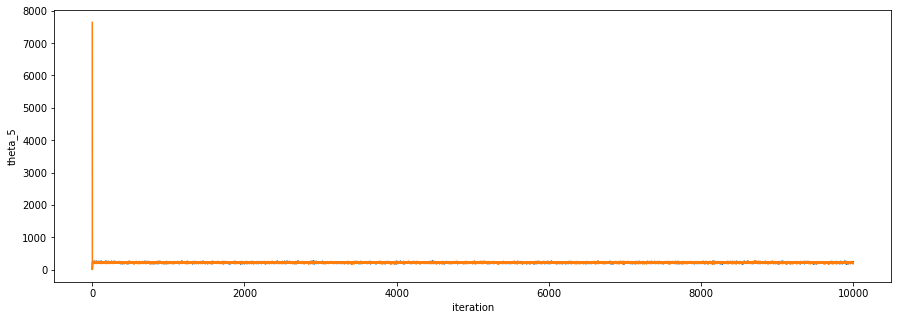

In [71]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'theta_5', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'theta_5', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

# Useful Functions

In [431]:
def sample_couple(prev_x, prev_y, tuning):
    log_p = lambda z: scipy.stats.multivariate_normal.logpdf(z, prev_x, tuning)
    log_q = lambda z: scipy.stats.multivariate_normal.logpdf(z, prev_y, tuning)
    
    x_prop = np.array([scipy.stats.multivariate_normal.rvs(prev_x, tuning)]).ravel()
    
    if np.log(random.uniform(0, 1)) <= log_q(x_prop) - log_p(x_prop):
        return x_prop, x_prop
    else:
        y_prop = np.array([scipy.stats.multivariate_normal.rvs(prev_y, tuning)]).ravel()
        while np.log(random.uniform(0, 1)) <= log_p(y_prop) - log_q(y_prop):
            y_prop = np.array([scipy.stats.multivariate_normal.rvs(prev_y, tuning)]).ravel()
            
        return x_prop, y_prop


In [432]:
def sample_couple_adaptive(prev_x, prev_y, tuning_x, tuning_y):
    log_p = lambda z: scipy.stats.multivariate_normal.logpdf(z, prev_x, tuning_x)
    log_q = lambda z: scipy.stats.multivariate_normal.logpdf(z, prev_y, tuning_y)
    
    x_prop = np.array([scipy.stats.multivariate_normal.rvs(prev_x, tuning_x)]).ravel()
    
    if np.log(random.uniform(0, 1)) <= log_q(x_prop) - log_p(x_prop):
        return x_prop, x_prop
    else:
        y_prop = np.array([scipy.stats.multivariate_normal.rvs(prev_y, tuning_y)]).ravel()
        while np.log(random.uniform(0, 1)) <= log_p(y_prop) - log_q(y_prop):
            y_prop = np.array([scipy.stats.multivariate_normal.rvs(prev_y, tuning_y)]).ravel()
            
        return x_prop, y_prop

In [433]:
def ar(prev, prop, crit, log_pdf):
    log_r = log_pdf(prop) - log_pdf(prev)
    if crit <= log_r:
        return prop, 1
    else:
        return prev, 0

In [434]:
def equality(px, py):
    if all (px == py):
        return True
    else:
        return False

In [435]:
def log_bb(data, params):
    if any(params <= 0) or any(params[2:] > 1):
        return -float("inf")
    else:
        return -len(data[0]) * np.log(scipy.special.beta(params[0], params[1])) + np.sum((data[0] + params[0] - 1) * np.log(params[2:])) + np.sum((data[1] - data[0] + params[1] - 1) * np.log(1 - params[2:]))
        

In [436]:
def log_pg(data, params):
    if any(params <= 0):
        return -float("inf")
    else:
        n = len(data)
        return params[0] * n * np.log(params[1]) - n * scipy.special.gammaln(params[0]) + np.sum((params[0] + data - 1) * np.log(params[2:])) - np.sum((params[1] + 1) * params[2:])




In [437]:
def log_ab(data, params):
    if any(params[-1] <= 0):
        return -float("inf")
    else:
        return -15 * np.log(scipy.special.beta(params[-1][0], params[-1][1])) + params[-1][0] * np.sum(np.log(params[0])) + params[-1][1] * np.sum(np.log(1 - params[0]))

In [438]:
def log_a(data, params):
    if params[-1][0] <= 0:
        return -float("inf")
    else:
        return 10 * params[-1][0] * np.log(params[0][0]) - 10 * np.log(scipy.special.gamma(params[-1][0])) + params[-1][0] * np.sum(np.log(params[1]))

In [439]:
def adaptive_converge1(px, py, Gx, Gy, sx, sy, eps, thresh):
    lx = Gx + eps
    ly = Gy + eps
    if all(px == py) and all(np.ravel(np.abs(np.exp(2 * sx) * lx - np.exp(2 * sy) * ly)) < thresh):
        return True
    else:
        return False

In [440]:
def adaptive_converge2(px, py, Gx, Gy, sx, sy, eps, thresh):
    lx = Gx + eps
    ly = Gy + eps
    if all(px == py) and all(np.ravel(np.abs((np.exp(2 * sx) * lx) / (np.exp(2 * sy) * ly))) < (1 + thresh)) and all(np.ravel(np.abs((np.exp(2 * sx) * lx) / (np.exp(2 * sy) * ly))) > (1 - thresh)):
        return True
    else:
        return False

# Unbiased Method \#1

Fully Metropolis

In [ ]:
def coupled_metropolis1(data, x_init, y_init, converge_fun, logpdf_fun, tuning, k = 100, lag = 1, maximum_iteration = 10000):
    params_x = [np.array(x_init)]
    params_y = [np.array(y_init)]
    
    iteration = 0
    
    logpdf = lambda z: logpdf_fun(data, z)
    
    while not converge_fun(params_x[-1], params_y[-1]):
        if lag <= iteration:
            x_prop, y_prop = sample_couple(params_x[-1], params_y[-1], tuning)
            log_u = np.log(random.uniform(0, 1))
            params_x.append(ar(params_x[-1], x_prop, log_u, logpdf)[0])
            params_y.append(ar(params_y[-1], y_prop, log_u, logpdf)[0])
        else:
            x_prop = scipy.stats.multivariate_normal.rvs(params_x[-1], tuning)
            log_u = np.log(random.uniform(0, 1))
            params_x.append(ar(params_x[-1], x_prop, log_u, logpdf)[0])
        
        iteration += 1
        
        if iteration == maximum_iteration:
            break
        
    print(iteration)
    
    if iteration != maximum_iteration:
        for i in range(k):
            x_prop = scipy.stats.multivariate_normal.rvs(params_x[-1], tuning)
            logu = np.log(random.uniform(0, 1))
            temp = ar(params_x[-1], x_prop, logu, logpdf)[0]
            params_x.append(temp)
            params_y.append(temp)
        
    return params_x, params_y, iteration
    

## Rat

In [1255]:
n = data1['n'].to_numpy()
y = data1['y'].to_numpy()
data = [y, n]

a_1 = 1
b_1 = 2
theta_1 = np.random.beta(y + a_1, n - y + b_1, 15)

a_2 = 20
b_2 = 50
theta_2 = np.random.beta(y + a_2, n - y + b_2, 15)

x_init = np.append([a_1, b_1], theta_1)
y_init = np.append([a_2, b_2], theta_2)

params_x, params_y, iteration = coupled_metropolis1(data, x_init, y_init, equality, log_bb, tuning = np.array([0.3, 1.1] + [0.01] * len(y)))

1000000


In [389]:
chain1_df = pd.DataFrame(params_x, columns = ['alpha', 'beta', 'theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8', 'theta9', 'theta10', 'theta11', 'theta12', 'theta13', 'theta14', 'theta15'])
chain2_df = pd.DataFrame(params_y, columns = ['alpha', 'beta', 'theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8', 'theta9', 'theta10', 'theta11', 'theta12', 'theta13', 'theta14', 'theta15'])
chain1_df = chain1_df.reset_index().rename(columns = {'index': 'iteration'})
chain2_df = chain2_df.reset_index().rename(columns = {'index': 'iteration'})

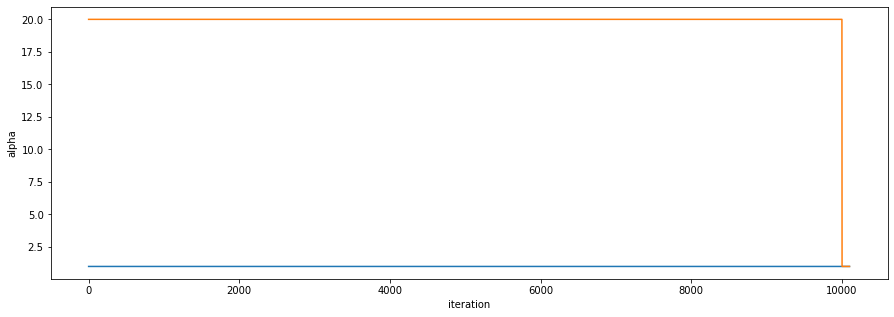

In [390]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'alpha', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'alpha', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

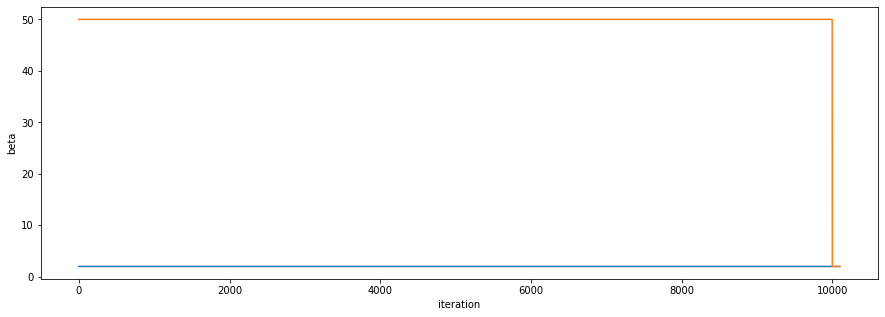

In [391]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'beta', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'beta', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

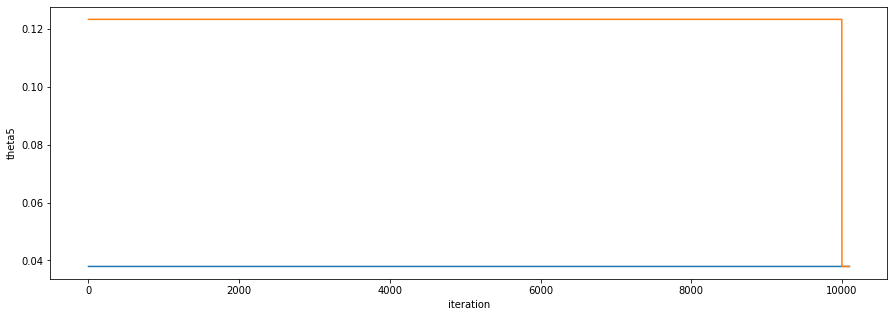

In [392]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'theta5', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'theta5', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

## Traffic

In [632]:
y = data2.iloc[2, 2:12].astype(int).to_numpy() + data2.iloc[2, 12:22].astype(int).to_numpy()

In [1256]:
data = y

a_1 = 50
b_1 = 20
theta_1 = np.random.gamma(50 + y, 21, len(y))

a_2 = 15
b_2 = 30
theta_2 = np.random.gamma(15 + y, 31, len(y))

x_init = np.append([a_1, b_1], theta_1)
y_init = np.append([a_2, b_2], theta_2)

params_x, params_y, iteration = coupled_metropolis1(data, x_init, y_init, equality, log_pg, tuning = np.array([0.3, 0.3] + [10] * len(y)))

910337


In [634]:
chain1_df = pd.DataFrame(params_x, columns = ['alpha', 'beta', 'theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8', 'theta9', 'theta10'])
chain2_df = pd.DataFrame(params_y, columns = ['alpha', 'beta', 'theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8', 'theta9', 'theta10'])
chain1_df = chain1_df.reset_index().rename(columns = {'index': 'iteration'})
chain2_df = chain2_df.reset_index().rename(columns = {'index': 'iteration'})

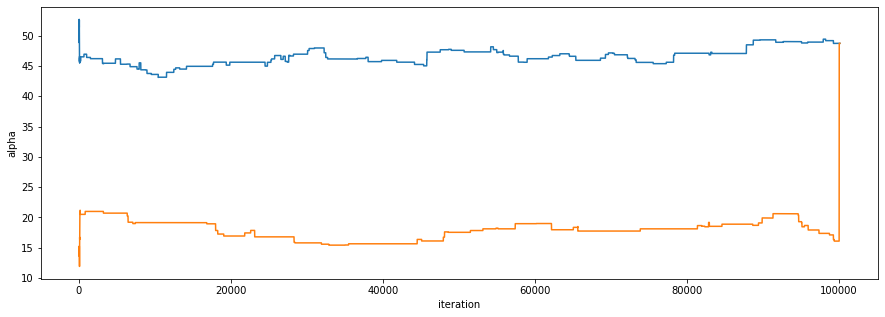

In [635]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'alpha', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'alpha', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

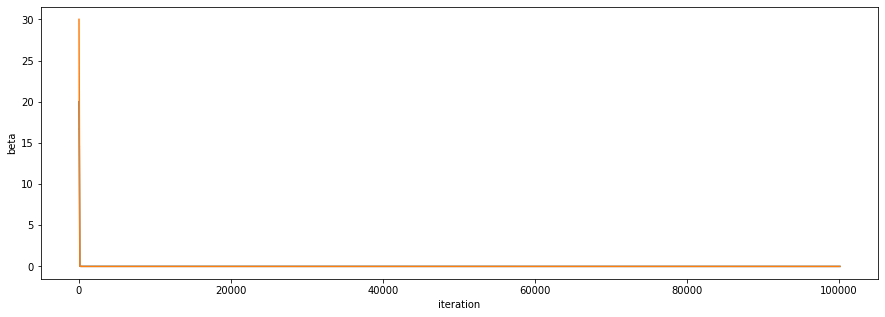

In [636]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'beta', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'beta', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

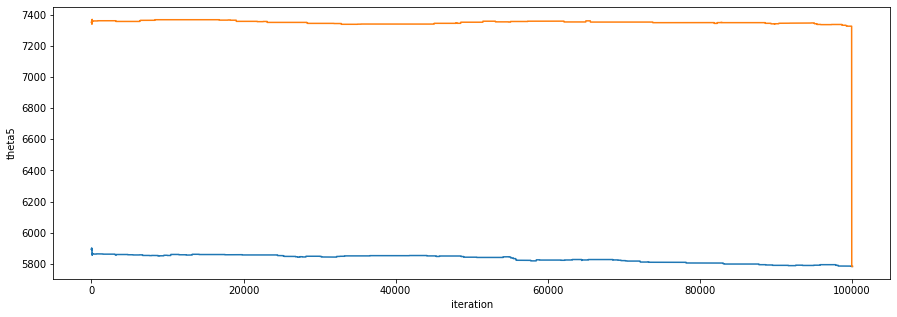

In [637]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'theta5', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'theta5', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

# Unbiased Method \#2

Metropolis step within Gibbs sampler

In [ ]:
def coupled_metropolis2(data, x_init, y_init, converge_fun, logpdf_fun, tuning, k = 100, lag = 1, maximum_iteration = 10000):
    params_x = [np.array(x_init)]
    params_y = [np.array(y_init)]
    
    iteration = 0
    
    while not converge_fun(params_x[-1], params_y[-1]):
        if lag <= iteration:
            x_prop, y_prop = sample_couple(params_x[-1], params_y[-1], tuning)

            for j in range(len(x_prop)):
                logu = np.log(random.uniform(0, 1))
                x_prop[j] = ar(params_x[-1][j], x_prop[j], logu, lambda z: logpdf_fun(data, np.hstack((params_x[-1][:j], z, params_x[-1][j + 1:]))))[0]
                y_prop[j] = ar(params_y[-1][j], y_prop[j], logu, lambda z: logpdf_fun(data, np.hstack((params_y[-1][:j], z, params_y[-1][j + 1:]))))[0]
            
            params_x.append(x_prop)
            params_y.append(y_prop)

        else:
            x_prop = scipy.stats.multivariate_normal.rvs(params_x[-1], tuning * np.ones(len(params_x[-1])))
            
            for j in range(len(x_prop)):
                logu = np.log(random.uniform(0, 1))
                x_prop[j] = ar(params_x[-1][j], x_prop[j], logu, lambda z: logpdf_fun(data, np.hstack((params_x[-1][:j], z, params_x[-1][j + 1:]))))[0]

            params_x.append(x_prop)
            
        iteration += 1
        if iteration == maximum_iteration:
            break
        
    print(iteration)

    if iteration != maximum_iteration:
        for i in range(k):
            x_prop = scipy.stats.multivariate_normal.rvs(params_x[-1], tuning * np.ones(len(params_x[-1])))
            for j in range(len(x_prop)):
                logu = np.log(random.uniform(0, 1))
                x_prop[j] = ar(params_x[-1][j], x_prop[j], logu, lambda z: logpdf_fun(data, np.hstack((params_x[-1][:j], z, params_x[-1][j + 1:]))))[0]
    
            params_x.append(x_prop)
            params_y.append(x_prop)
        
    return params_x, params_y, iteration
    

## Rat

In [1258]:
n = data1['n'].to_numpy()
y = data1['y'].to_numpy()
data = [y, n]

a_1 = 1
b_1 = 2
theta_1 = np.random.beta(y + a_1, n - y + b_1, 15)

a_2 = 20
b_2 = 50
theta_2 = np.random.beta(y + a_2, n - y + b_2, 15)

x_init = np.append([a_1, b_1], theta_1)
y_init = np.append([a_2, b_2], theta_2)

params_x, params_y, iteration = coupled_metropolis2(data, x_init, y_init, equality, log_bb, tuning = np.array([0.3, 1.1] + [0.01] * 15), k = 1000)

684


In [1151]:
chain1_df = pd.DataFrame(params_x, columns = ['alpha', 'beta', 'theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8', 'theta9', 'theta10', 'theta11', 'theta12', 'theta13', 'theta14', 'theta15'])
chain2_df = pd.DataFrame(params_y, columns = ['alpha', 'beta', 'theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8', 'theta9', 'theta10', 'theta11', 'theta12', 'theta13', 'theta14', 'theta15'])
chain1_df = chain1_df.reset_index().rename(columns = {'index': 'iteration'})
chain2_df = chain2_df.reset_index().rename(columns = {'index': 'iteration'})

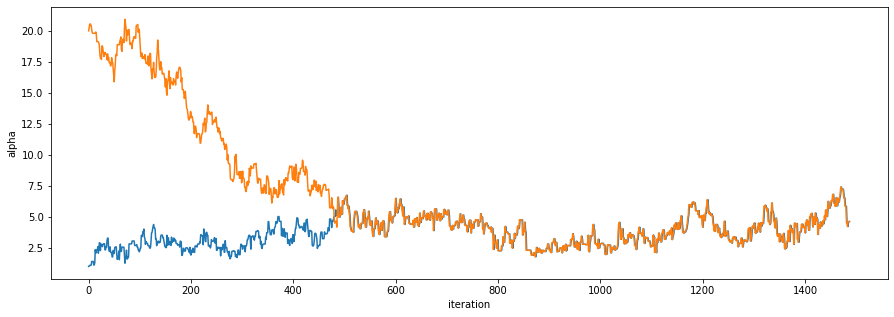

In [1152]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'alpha', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'alpha', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

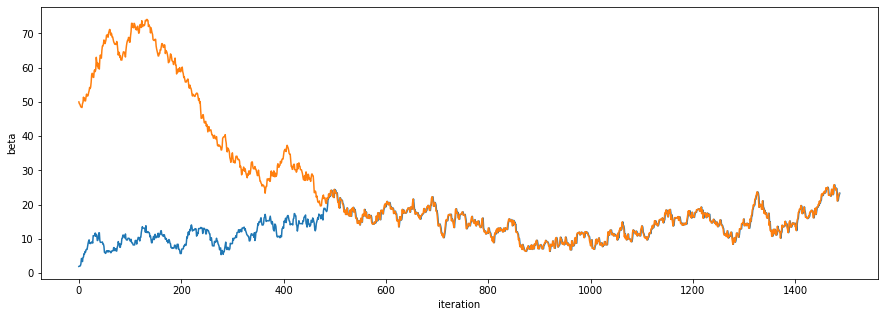

In [1153]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'beta', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'beta', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

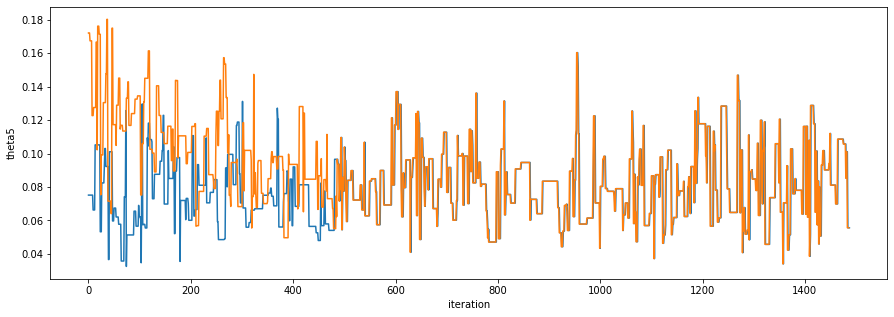

In [1154]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'theta5', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'theta5', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

## Traffic

In [1259]:
y = data2.iloc[2, 2:12].astype(int).to_numpy() + data2.iloc[2, 12:22].astype(int).to_numpy()

data = y

a_1 = 50
b_1 = 20
theta_1 = np.random.gamma(50 + y, 21, len(y))

a_2 = 15
b_2 = 30
theta_2 = np.random.gamma(15 + y, 31, len(y))

x_init = np.append([a_1, b_1], theta_1)
y_init = np.append([a_2, b_2], theta_2)

params_x, params_y, iteration = coupled_metropolis2(data, x_init, y_init, equality, log_pg, tuning = np.array([2.7, 0.3] + [500] * len(y)))

567


In [1221]:
chain1_df = pd.DataFrame(params_x, columns = ['alpha', 'beta', 'theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8', 'theta9', 'theta10'])
chain2_df = pd.DataFrame(params_y, columns = ['alpha', 'beta', 'theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8', 'theta9', 'theta10'])
chain1_df = chain1_df.reset_index().rename(columns = {'index': 'iteration'})
chain2_df = chain2_df.reset_index().rename(columns = {'index': 'iteration'})

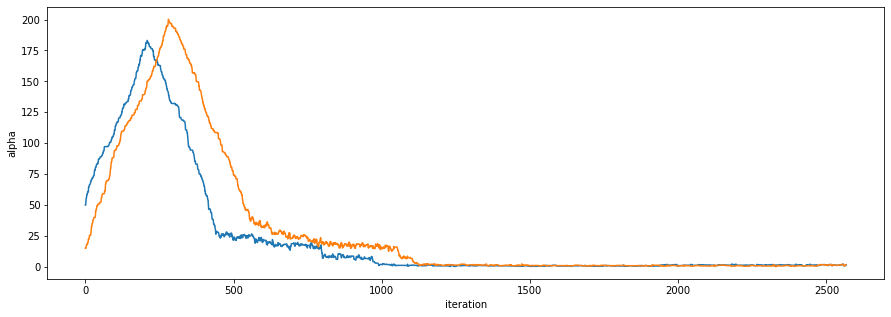

In [1222]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'alpha', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'alpha', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

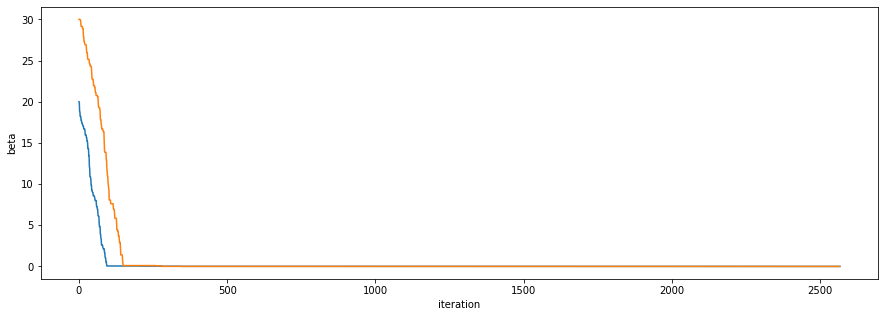

In [1223]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'beta', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'beta', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

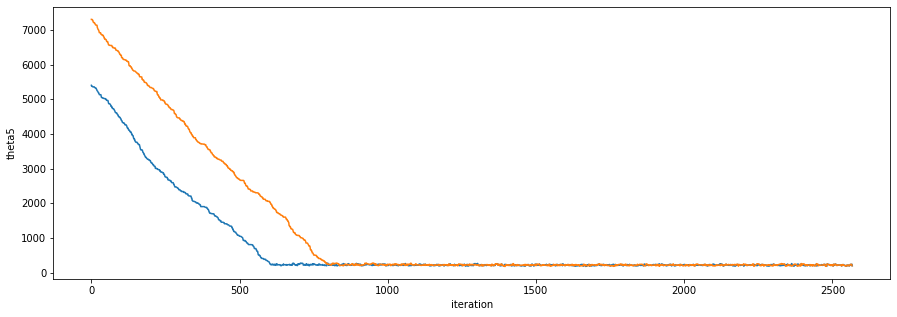

In [1224]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'theta5', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'theta5', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

# Unbiased Method \#3

Gibbs sampler

In [465]:
def coupled_metropolis_gibbs(data, x_init, y_init, converge_fun, logpdf_fun, tuning, gibbs_vec, k = 100, lag = 1, maximum_iteration = 10000):
    params_x = [x_init]
    params_y = [y_init]
    
    iteration = 0
    
    while not converge_fun(params_x[-1][-1], params_y[-1][-1]):
        if lag <= iteration:
            temp_x = np.zeros(len(x_init), dtype = 'object')
            temp_y = np.zeros(len(x_init), dtype = 'object')

            for j in range(len(gibbs_vec)):
                temp_x[j] = gibbs_vec[j](data, params_x[-1])
                temp_y[j] = gibbs_vec[j](data, params_y[-1])

            x_prop, y_prop = sample_couple(params_x[-1][-1], params_y[-1][-1], tuning)

            for j in range(len(x_prop)):
                logu = np.log(random.uniform(0, 1))
                x_prop[j], a = ar(params_x[-1][-1][j], x_prop[j], logu, lambda z: logpdf_fun(data, np.array(list(params_x[-1][:-1]) + [np.hstack((params_x[-1][-1][:j], z, params_x[-1][-1][j + 1:]))], dtype = 'object')))
                y_prop[j], a = ar(params_y[-1][-1][j], y_prop[j], logu, lambda z: logpdf_fun(data, np.array(list(params_y[-1][:-1]) + [np.hstack((params_y[-1][-1][:j], z, params_y[-1][-1][j + 1:]))], dtype = 'object')))
            
            temp_x[-1] = x_prop
            temp_y[-1] = y_prop
            
            params_x.append(temp_x)
            params_y.append(temp_y)

        else:
            temp_x = np.zeros(len(x_init), dtype = 'object')
            for j in range(len(gibbs_vec)):
                temp_x[j] = gibbs_vec[j](data, params_x[-1])
            
            x_prop = np.array([scipy.stats.multivariate_normal.rvs(params_x[-1][-1], tuning * np.ones(len(params_x[-1][-1])))]).ravel()

            for j in range(len(x_prop)):
                logu = np.log(random.uniform(0, 1))                
                x_prop[j], a = ar(params_x[-1][-1][j], x_prop[j], logu, lambda z: logpdf_fun(data, np.array(list(params_x[-1][:-1]) + [np.hstack((params_x[-1][-1][:j], z, params_x[-1][-1][j + 1:]))], dtype = 'object')))
            
            temp_x[-1] = x_prop
            
            params_x.append(temp_x)            
            
        iteration += 1
        if iteration == maximum_iteration:
            break
        
    print(iteration)

    if iteration != maximum_iteration:
        for i in range(k):
            temp_x = np.zeros(len(x_init), dtype = 'object')
            for j in range(len(gibbs_vec)):
                temp_x[j] = gibbs_vec[j](data, params_x[-1])
                
            x_prop = np.array([scipy.stats.multivariate_normal.rvs(params_x[-1][-1], tuning * np.ones(len(params_x[-1][-1])))]).ravel()
    
            for j in range(len(x_prop)):
                logu = np.log(random.uniform(0, 1))
                x_prop[j], a = ar(params_x[-1][-1][j], x_prop[j], logu, lambda z: logpdf_fun(data, np.array(list(params_x[-1][:-1]) + [np.hstack((params_x[-1][-1][:j], z, params_x[-1][-1][j + 1:]))], dtype = 'object')))
    
            temp_x[-1] = x_prop
    
            params_x.append(temp_x)   
            params_y.append(temp_x)

    return params_x, params_y, iteration
    

## Rat

In [466]:
n = data1['n'].to_numpy()
y = data1['y'].to_numpy()
data = [y, n]

a_1 = 1
b_1 = 2
theta_1 = np.random.beta(y + a_1, n - y + b_1, 15)

a_2 = 20
b_2 = 50
theta_2 = np.random.beta(y + a_2, n - y + b_2, 15)

x_init = np.array((np.array(theta_1), np.array([a_1, b_1])), dtype = 'object')
y_init = np.array((np.array(theta_2), np.array([a_2, b_2])), dtype = 'object')

thetas = lambda data, params: np.random.beta(data[0] + params[-1][0], data[1] - data[0] + params[-1][1], 15)
gibbs_vec = [thetas]

params_x, params_y, iteration = coupled_metropolis_gibbs(data, x_init, y_init, equality, log_ab, tuning = np.array([0.3, 1.1]), gibbs_vec = gibbs_vec, k = 1000)


802


In [467]:
chain1_df = pd.DataFrame([np.hstack(x) for x in params_x], columns = ['theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8', 'theta9', 'theta10', 'theta11', 'theta12', 'theta13', 'theta14', 'theta15', 'alpha', 'beta'])
chain2_df = pd.DataFrame([np.hstack(y) for y in params_y], columns = ['theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8', 'theta9', 'theta10', 'theta11', 'theta12', 'theta13', 'theta14', 'theta15', 'alpha', 'beta'])
chain1_df = chain1_df.reset_index().rename(columns = {'index': 'iteration'})
chain2_df = chain2_df.reset_index().rename(columns = {'index': 'iteration'})

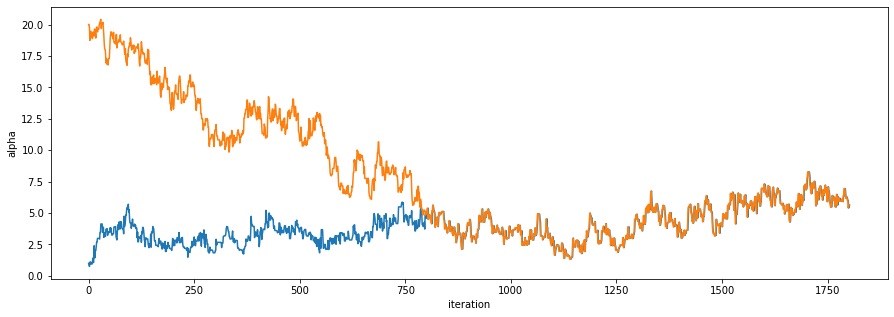

In [468]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'alpha', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'alpha', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

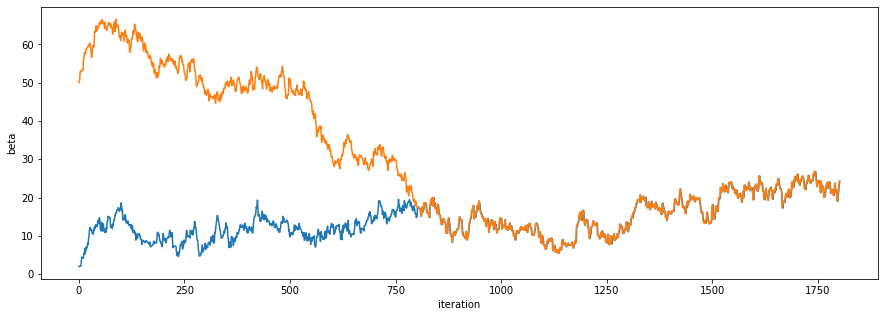

In [469]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'beta', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'beta', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

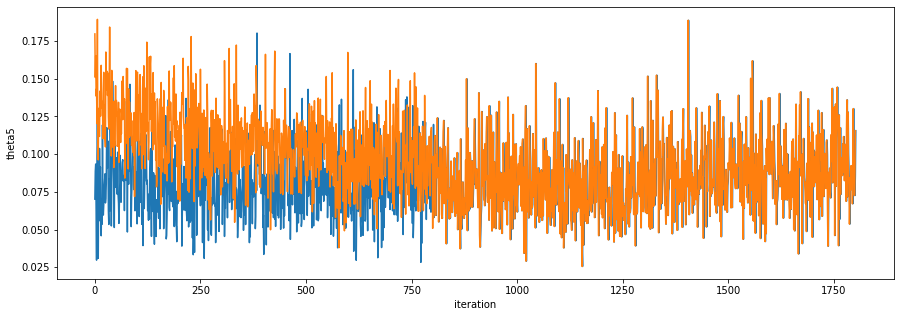

In [470]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'theta5', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'theta5', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

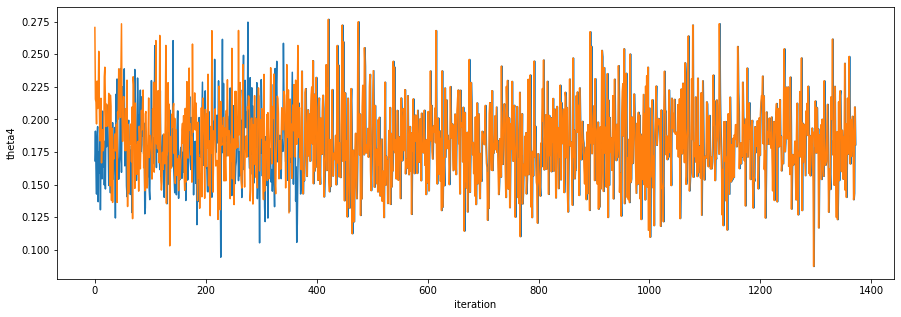

In [346]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'theta4', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'theta4', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

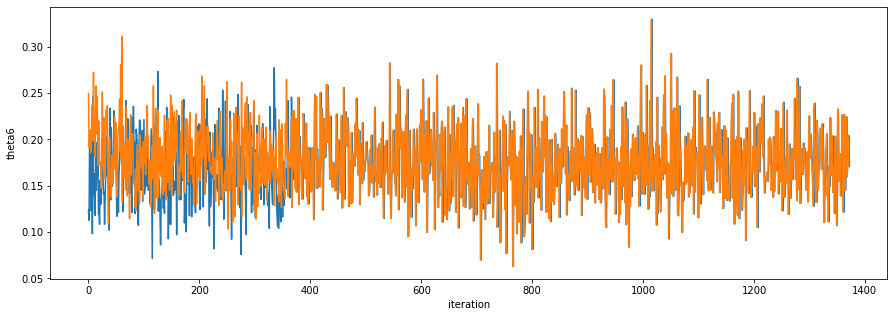

In [347]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'theta6', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'theta6', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

## Traffic

In [1057]:
y = data2.iloc[2, 2:12].astype(int).to_numpy() + data2.iloc[2, 12:22].astype(int).to_numpy()
data = [y]

a_1 = 50
b_1 = 20
theta_1 = np.random.gamma(50 + y, 21, len(y))

a_2 = 15
b_2 = 30
theta_2 = np.random.gamma(15 + y, 31, len(y))

x_init = np.array((np.array([b_1]), np.array(theta_1), np.array([a_1])), dtype = 'object')
y_init = np.array((np.array([b_2]), np.array(theta_2), np.array([a_2])), dtype = 'object')

beta = lambda data, params: np.array([np.random.gamma(10 * params[-1][0] + 1, scale = 1 / (np.sum(params[1])))])
thetas = lambda data, params: np.random.gamma(params[-1][0] + data[0], scale = 1 / (params[0][0] + 1), size = 10)
gibbs_vec = [beta, thetas]

params_x, params_y, iteration = coupled_metropolis_gibbs(data, x_init, y_init, equality, log_a, tuning = np.array([0.3]), gibbs_vec = gibbs_vec, k = 1000)


233


In [1058]:
chain1_df = pd.DataFrame([np.hstack(x) for x in params_x], columns = ['beta', 'theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8', 'theta9', 'theta10', 'alpha'])
chain2_df = pd.DataFrame([np.hstack(y) for y in params_y], columns = ['beta', 'theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8', 'theta9', 'theta10', 'alpha'])
chain1_df = chain1_df.reset_index().rename(columns = {'index': 'iteration'})
chain2_df = chain2_df.reset_index().rename(columns = {'index': 'iteration'})

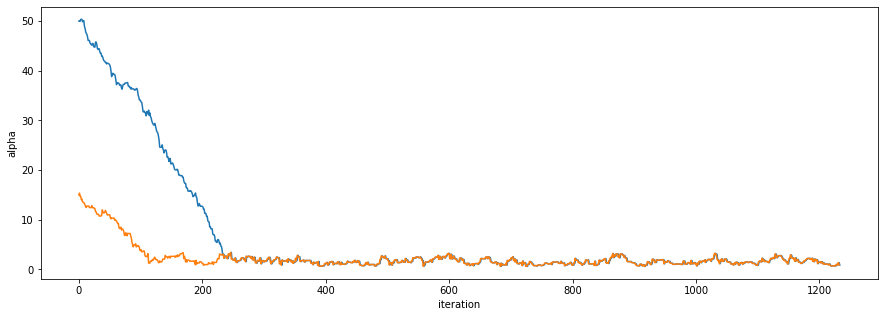

In [1059]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'alpha', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'alpha', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

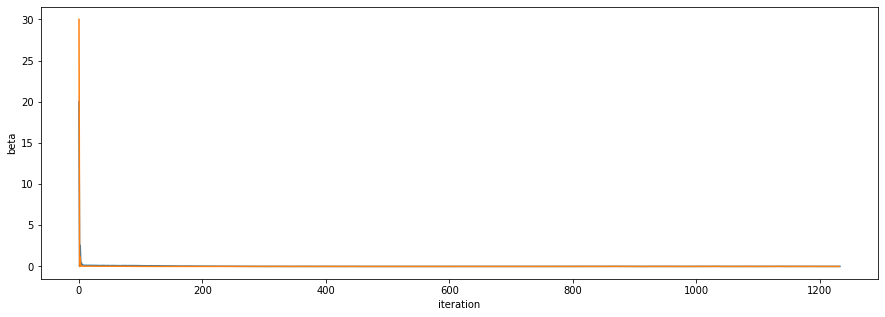

In [1060]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'beta', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'beta', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

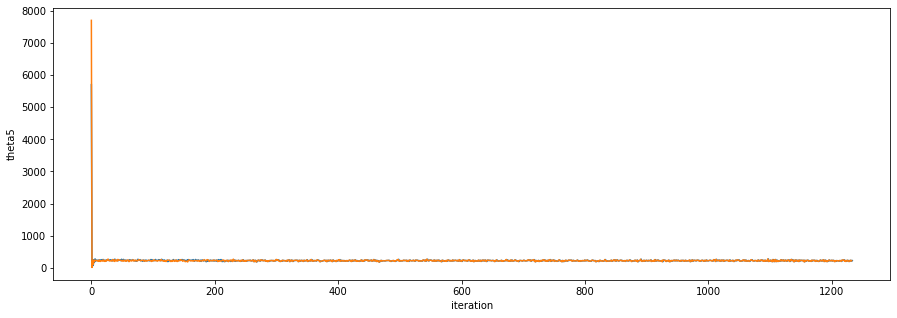

In [1061]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'theta5', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'theta5', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

# Separate Adaptive MCMC

In [34]:
# For fully Metropolis
def adaptive_metro1(data, init, logpdf_fun, eps = 0.01):
    params = [np.array(init)]
    accept = 1
    total = 1
    
    iteration = 0
    mu = params[-1]
    
    Gamma = np.zeros((len(params[-1]), len(params[-1])))
                     
    sigma = 0.7

    n = 0
    gamma = 1
    
    logpdf = lambda z: logpdf_fun(data, z)

    #run until we converge to the target acceptance rate

    # use accept rate of last 100 iterations?
    #while not round(accept/total, 3) == 0.3:  
    while True:
    #while not np.sum(accepts)/1000 == 0.3:
        lamb = Gamma + eps * np.eye(len(Gamma))

        prop = np.random.multivariate_normal(mean = params[-1], cov = np.exp(2 * sigma) * lamb)

        log_u = np.log(random.uniform(0, 1))

        log_r = min(0, logpdf(prop) - logpdf(params[-1]))

        if log_u <= log_r:
            accept += 1
            params.append(prop)
        else:
            params.append(params[-1])

        total += 1
        n += 1

        m = params[-1] - mu
        Gamma = Gamma + (np.matmul(np.atleast_2d(m).T, np.atleast_2d(m)) - Gamma) / n

        mu = mu + (params[-1] - mu) / n

        gamma = np.sqrt(1/n)
        sigma = sigma + gamma * (np.exp(log_r) - 0.3)

        iteration += 1

        if iteration == 1000000:
            break

        
    print(iteration)
    
    return params, mu, Gamma, sigma, iteration, accept/total
    

In [358]:
# For Metropolis within Gibbs

def adaptive_metro2(data, init, logpdf_fun, eps = 0.01):
    params = [np.array(init)]
    accept = 1
    total = 1
    
    iteration = 0
    mu = params[-1]
    
    Gamma = np.zeros(len(params[-1]))
    sigma = np.ones(len(params[-1])) * 0.7

    n = 0
    gamma = 1
    
    #run until we converge to the target acceptance rate

    # use accept rate of last 100 iterations?
    #while not round(accept/total, 3) == 0.3:  
    while True:
    #while not np.sum(accepts)/1000 == 0.3:
        temp = np.zeros(len(params[-1]))
        log_r = np.zeros(len(params[-1]))
        
        for j in range(len(params[-1])):
            lamb = Gamma[j] + eps
            logpdf = lambda z: logpdf_fun(data, np.hstack((params[-1][:j], z, params[-1][j + 1:])))
            prop = np.random.normal(params[-1][j], np.sqrt(np.exp(2 * sigma[j]) * lamb))

            log_u = np.log(random.uniform(0, 1))
            log_r[j] = min(0, logpdf(prop) - logpdf(params[-1][j]))


            if log_u <= log_r[j]:
                accept += 1
                temp[j] = prop
            else:
                temp[j] = params[-1][j]

        params.append(temp)

        total += len(params[-1])
        n += 1

        m = params[-1] - mu
        Gamma = Gamma + (np.power(m, 2) - Gamma) / n
        
        mu = mu + (params[-1] - mu)/n

        gamma = np.sqrt(1/n)
        sigma = sigma + gamma * (np.exp(log_r) - 0.3)

        iteration += 1

        if iteration == 100000:
            break

        
    print(iteration)
    
    return params, mu, Gamma, sigma, iteration, accept/total
    

In [306]:
# For Gibbs

def adaptive_gibbs(data, init, logpdf_fun, gibbs_vec, eps = 0.01):
    params = [np.array(init)]
    accept = 1
    total = 1
    
    iteration = 0
    mu = params[-1][-1]
    
    Gamma = np.zeros(len(params[-1][-1]))
    sigma = np.ones(len(params[-1][-1])) * 0.7

    n = 0
    gamma = 1
    
    #run until we converge to the target acceptance rate
 
    while True:
        temp = np.zeros(len(x_init), dtype = 'object')
        
        for j in range(len(gibbs_vec)):
            temp[j] = gibbs_vec[j](data, params[-1])
        
        prop_temp = np.zeros(len(params[-1][-1]))
        log_r = np.zeros(len(params[-1][-1]))

        for j in range(len(params[-1][-1])):
            lamb = Gamma[j] + eps
            logpdf = lambda z: logpdf_fun(data, np.array(list(params[-1][:-1]) + [np.hstack((params[-1][-1][:j], z, params[-1][-1][j + 1:]))], dtype = 'object'))
            
            prop = np.random.normal(params[-1][-1][j], np.sqrt(np.exp(2 * sigma[j]) * lamb))

            log_u = np.log(random.uniform(0, 1))
            log_r[j] = min(0, logpdf(prop) - logpdf(params[-1][-1][j]))

            if log_u <= log_r[j]:
                accept += 1
                prop_temp[j] = prop
            else:
                prop_temp[j] = params[-1][-1][j]

        temp[-1] = prop_temp

        params.append(temp)

        total += len(params[-1][-1])
        n += 1

        m = params[-1][-1] - mu
        Gamma = Gamma + (np.power(m, 2) - Gamma) / n
        
        mu = mu + (params[-1][-1] - mu)/n

        gamma = np.sqrt(1/n)
        sigma = sigma + gamma * (np.exp(log_r) - 0.3)

        iteration += 1

        if iteration == 100000:
            break

        
    print(iteration)
    
    return params, mu, Gamma, sigma, iteration, accept/total
    

## Rat

### Fully Metropolis

In [59]:
n = data1['n'].to_numpy()
y = data1['y'].to_numpy()
data = [y, n]

a_1 = 1
b_1 = 2
theta_1 = np.random.beta(y + a_1, n - y + b_1, 15)

a_2 = 20
b_2 = 50
theta_2 = np.random.beta(y + a_2, n - y + b_2, 15)

x_init = np.append([a_1, b_1], theta_1)
y_init = np.append([a_2, b_2], theta_2)

params, mu, tuning, c, iteration, rate = adaptive_metro1(data, x_init, log_bb)

1000000


In [312]:
chain_df = pd.DataFrame(params, columns = ['alpha', 'beta', 'theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8', 'theta9', 'theta10', 'theta11', 'theta12', 'theta13', 'theta14', 'theta15'])
chain_df = chain_df.reset_index().rename(columns = {'index': 'iteration'})


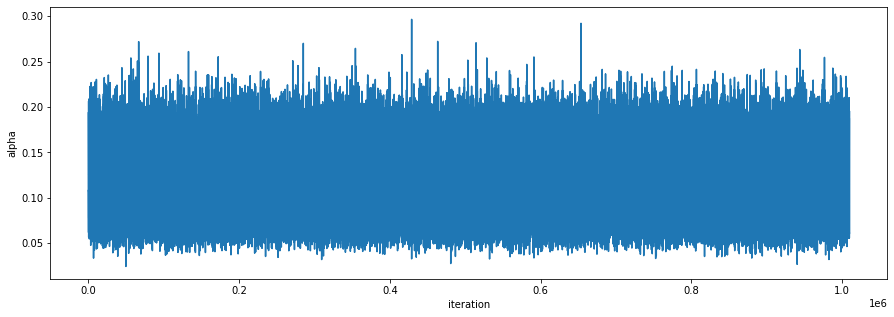

In [313]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain_df, x = 'iteration', y = 'alpha', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

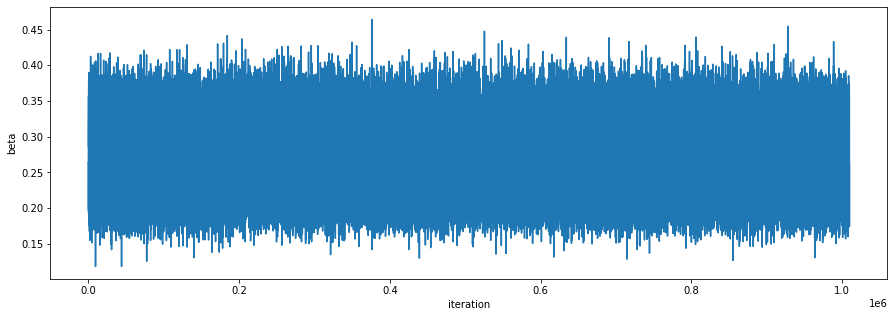

In [314]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain_df, x = 'iteration', y = 'beta', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

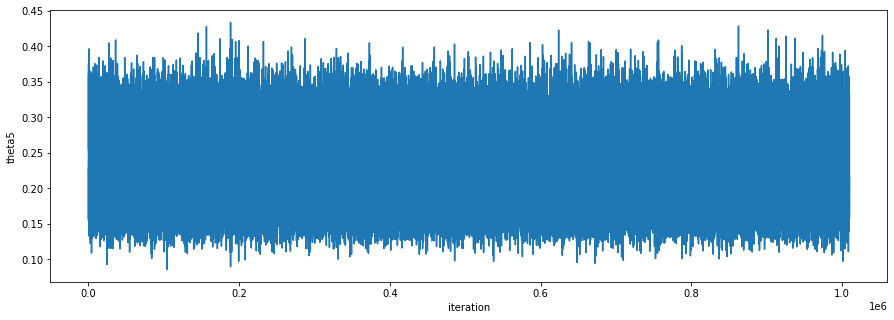

In [315]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain_df, x = 'iteration', y = 'theta5', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

In [70]:
n = data1['n'].to_numpy()
y = data1['y'].to_numpy()
data = [y, n]

a_1 = 1
b_1 = 2
theta_1 = np.random.beta(y + a_1, n - y + b_1, 15)

a_2 = 20
b_2 = 50
theta_2 = np.random.beta(y + a_2, n - y + b_2, 15)

x_init = np.append([a_1, b_1], theta_1)
y_init = np.append([a_2, b_2], theta_2)

lamb = tuning + 0.01 * np.eye(len(tuning))

params_x, params_y, iteration = coupled_metropolis1(data, x_init, y_init, equality, log_bb, tuning = np.exp(2 * c) * lamb, k = 10000, maximum_iteration = 1000000)


674546


In [71]:
chain1_df = pd.DataFrame(params_x, columns = ['alpha', 'beta', 'theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8', 'theta9', 'theta10', 'theta11', 'theta12', 'theta13', 'theta14', 'theta15'])
chain2_df = pd.DataFrame(params_y, columns = ['alpha', 'beta', 'theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8', 'theta9', 'theta10', 'theta11', 'theta12', 'theta13', 'theta14', 'theta15'])
chain1_df = chain1_df.reset_index().rename(columns = {'index': 'iteration'})
chain2_df = chain2_df.reset_index().rename(columns = {'index': 'iteration'})

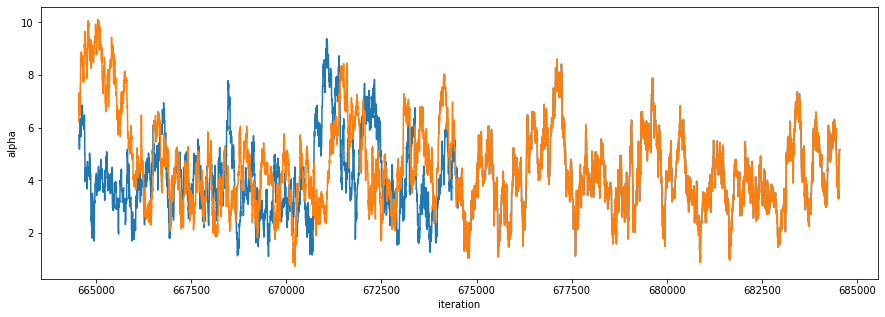

In [72]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df[-20000:], x = 'iteration', y = 'alpha', ax = ax)
sns.lineplot(data = chain2_df[-20000:], x = 'iteration', y = 'alpha', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

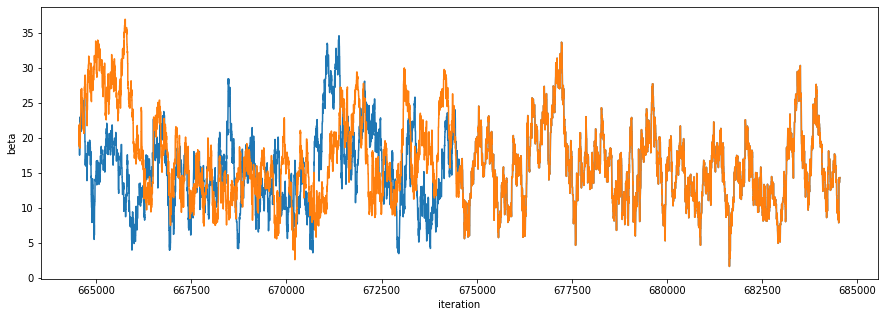

In [73]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df[-20000:], x = 'iteration', y = 'beta', ax = ax)
sns.lineplot(data = chain2_df[-20000:], x = 'iteration', y = 'beta', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

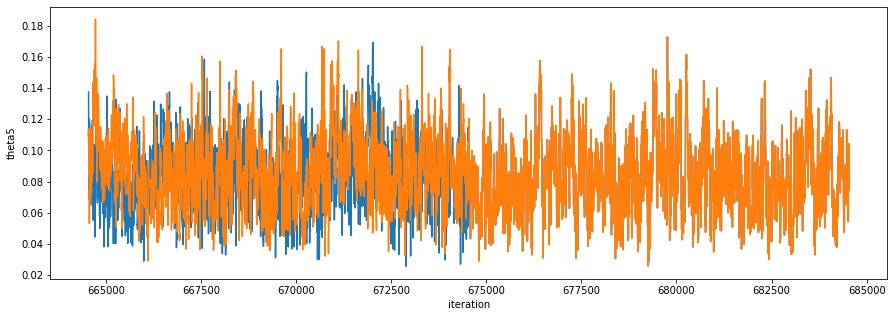

In [74]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df[-20000:], x = 'iteration', y = 'theta5', ax = ax)
sns.lineplot(data = chain2_df[-20000:], x = 'iteration', y = 'theta5', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

### Metropolis within Gibbs

In [359]:
n = data1['n'].to_numpy()
y = data1['y'].to_numpy()
data = [y, n]

a_1 = 1
b_1 = 2
theta_1 = np.random.beta(y + a_1, n - y + b_1, 15)

a_2 = 20
b_2 = 50
theta_2 = np.random.beta(y + a_2, n - y + b_2, 15)

x_init = np.append([a_1, b_1], theta_1)
y_init = np.append([a_2, b_2], theta_2)

params, mu, tuning, c, iteration, rate = adaptive_metro2(data, x_init, log_bb)

100000


In [360]:
len(data[0])

15

In [361]:
lamb = tuning + 0.01

params_x, params_y, iteration = coupled_metropolis2(data, x_init, y_init, equality, log_bb, tuning = np.exp(2 * c) * lamb, k = 10000)


56


In [362]:
chain1_df = pd.DataFrame(params_x, columns = ['alpha', 'beta', 'theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8', 'theta9', 'theta10', 'theta11', 'theta12', 'theta13', 'theta14', 'theta15'])
chain2_df = pd.DataFrame(params_y, columns = ['alpha', 'beta', 'theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8', 'theta9', 'theta10', 'theta11', 'theta12', 'theta13', 'theta14', 'theta15'])
chain1_df = chain1_df.reset_index().rename(columns = {'index': 'iteration'})
chain2_df = chain2_df.reset_index().rename(columns = {'index': 'iteration'})

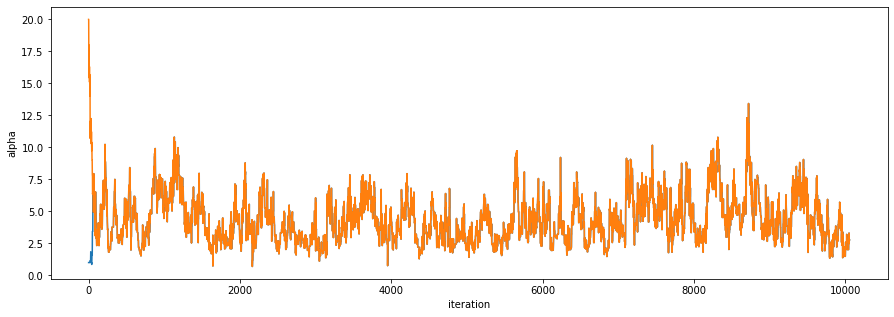

In [363]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df[-20000:], x = 'iteration', y = 'alpha', ax = ax)
sns.lineplot(data = chain2_df[-20000:], x = 'iteration', y = 'alpha', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

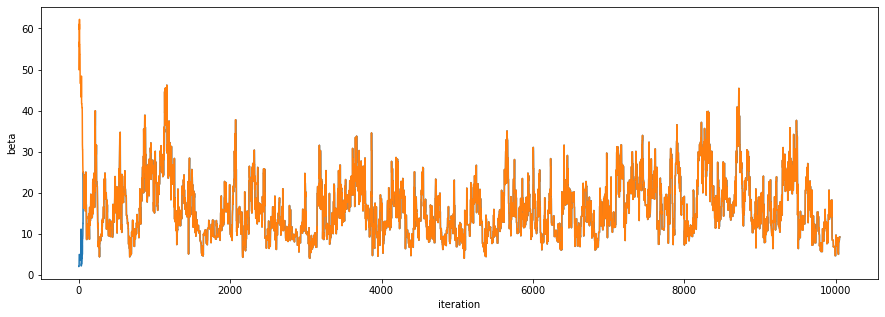

In [364]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df[-20000:], x = 'iteration', y = 'beta', ax = ax)
sns.lineplot(data = chain2_df[-20000:], x = 'iteration', y = 'beta', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

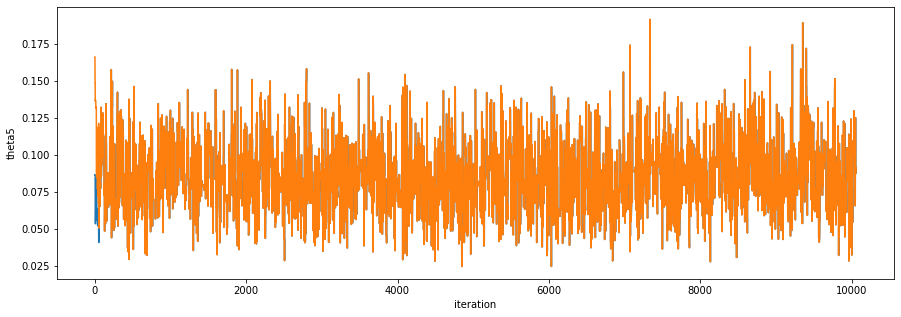

In [365]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df[-20000:], x = 'iteration', y = 'theta5', ax = ax)
sns.lineplot(data = chain2_df[-20000:], x = 'iteration', y = 'theta5', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

### Gibbs

In [348]:
n = data1['n'].to_numpy()
y = data1['y'].to_numpy()
data = [y, n]

a_1 = 1
b_1 = 2
theta_1 = np.random.beta(y + a_1, n - y + b_1, 15)

a_2 = 20
b_2 = 50
theta_2 = np.random.beta(y + a_2, n - y + b_2, 15)

x_init = np.array((np.array(theta_1), np.array([a_1, b_1])), dtype = 'object')
y_init = np.array((np.array(theta_2), np.array([a_2, b_2])), dtype = 'object')

thetas = lambda data, params: np.random.beta(data[0] + params[-1][0], data[1] - data[0] + params[-1][1], 15)
gibbs_vec = [thetas]

params, mu, tuning, c, iteration, rate = adaptive_gibbs(data, x_init, log_ab, gibbs_vec)

100000


In [349]:
chain_df = pd.DataFrame([np.hstack(x) for x in params], columns = ['theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8', 'theta9', 'theta10', 'theta11', 'theta12', 'theta13', 'theta14', 'theta15', 'alpha', 'beta'])
chain_df = chain_df.reset_index().rename(columns = {'index': 'iteration'})


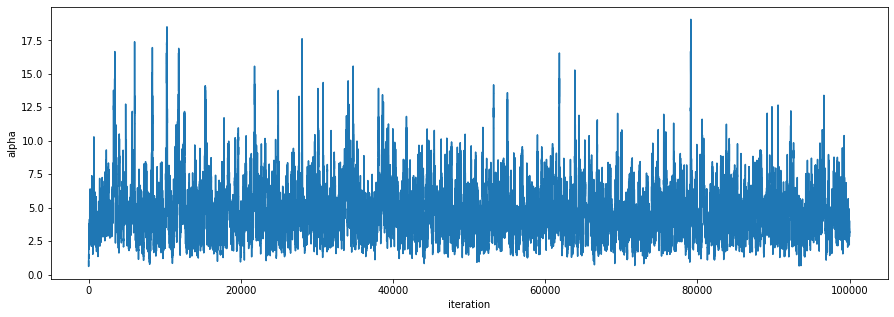

In [350]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain_df, x = 'iteration', y = 'alpha', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

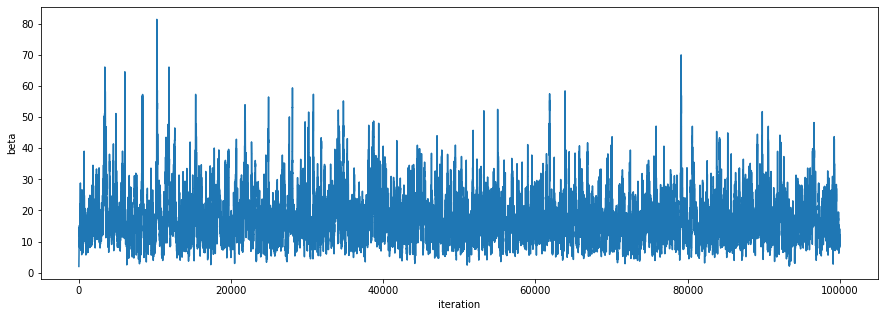

In [351]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain_df, x = 'iteration', y = 'beta', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

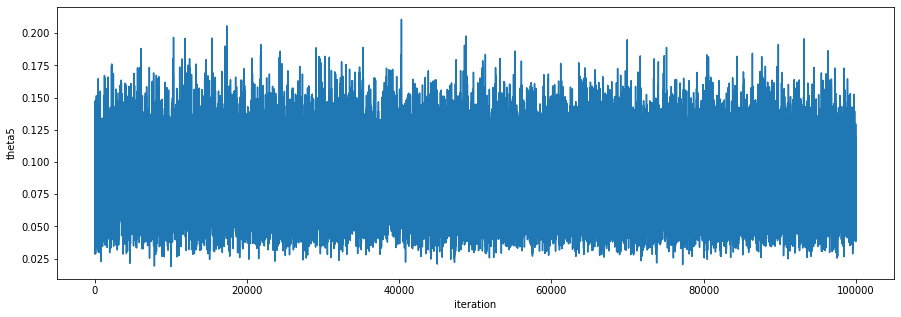

In [352]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain_df, x = 'iteration', y = 'theta5', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

In [353]:
lamb = tuning + 0.01

params_x, params_y, iteration = coupled_metropolis_gibbs(data, x_init, y_init, equality, log_ab, tuning = np.exp(2 * c) * lamb, gibbs_vec = gibbs_vec, k = 1000)


86


In [354]:
chain1_df = pd.DataFrame([np.hstack(x) for x in params_x], columns = ['theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8', 'theta9', 'theta10', 'theta11', 'theta12', 'theta13', 'theta14', 'theta15', 'alpha', 'beta'])
chain2_df = pd.DataFrame([np.hstack(y) for y in params_y], columns = ['theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8', 'theta9', 'theta10', 'theta11', 'theta12', 'theta13', 'theta14', 'theta15', 'alpha', 'beta'])

chain1_df = chain1_df.reset_index().rename(columns = {'index': 'iteration'})
chain2_df = chain2_df.reset_index().rename(columns = {'index': 'iteration'})


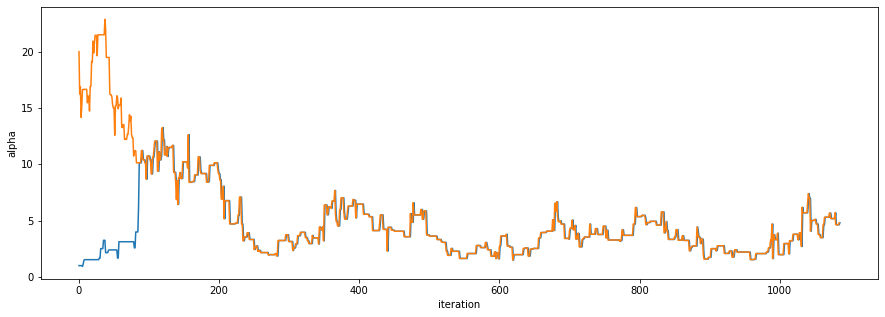

In [355]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'alpha', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'alpha', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

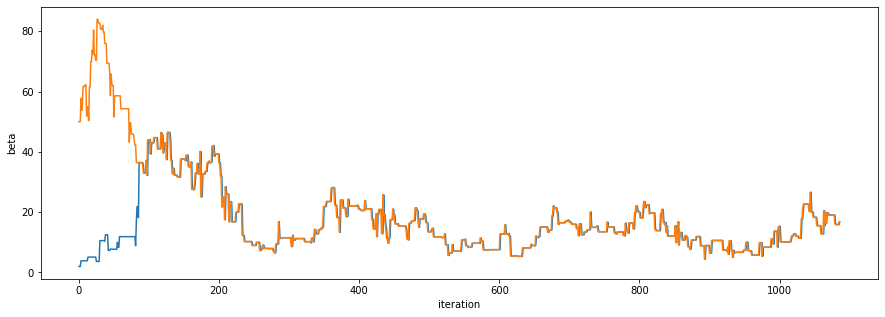

In [356]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'beta', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'beta', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

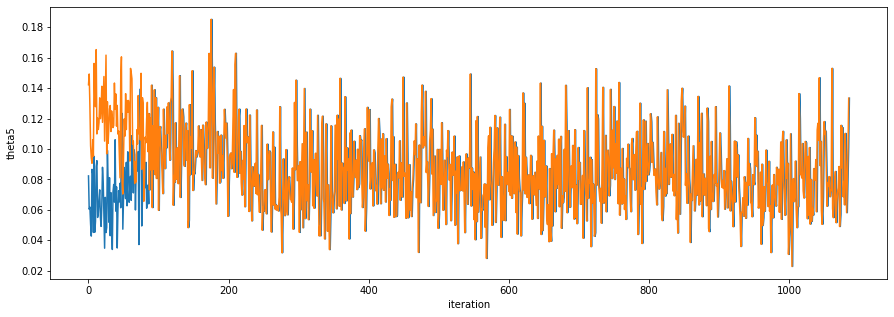

In [357]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'theta5', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'theta5', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

## Traffic

### Fully Metropolis

In [1118]:
y = data2.iloc[2, 2:12].astype(int).to_numpy() + data2.iloc[2, 12:22].astype(int).to_numpy()

In [1119]:
data = y

a_1 = 50
b_1 = 20
theta_1 = np.random.gamma(50 + y, 21, len(y))

a_2 = 15
b_2 = 30
theta_2 = np.random.gamma(15 + y, 31, len(y))

x_init = np.append([a_1, b_1], theta_1)
y_init = np.append([a_2, b_2], theta_2)

params, mu, tuning, c, iteration, rate = adaptive_metro1(data, y_init, log_pg)



1000000


In [1120]:
rate

0.30026269973730024

In [1114]:
chain_df = pd.DataFrame(params, columns = ['alpha', 'beta', 'theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8', 'theta9', 'theta10'])
chain_df = chain_df.reset_index().rename(columns = {'index': 'iteration'})

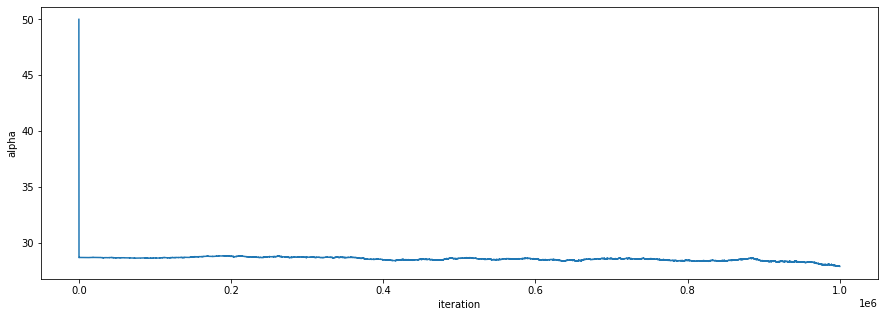

In [1115]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain_df, x = 'iteration', y = 'alpha', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

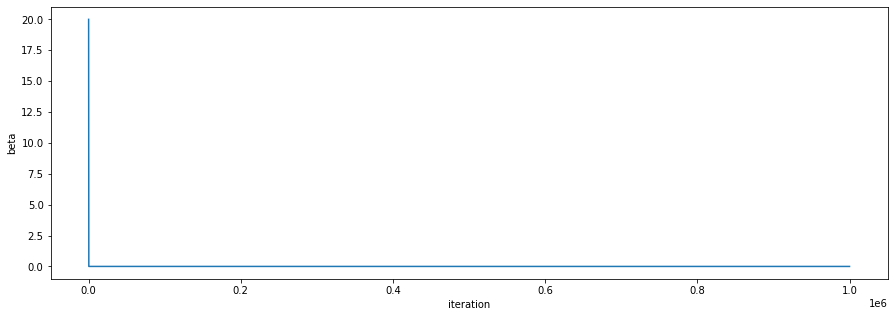

In [1116]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain_df, x = 'iteration', y = 'beta', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

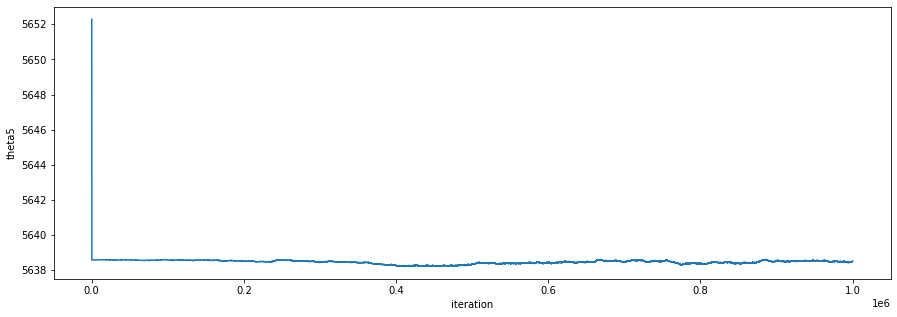

In [1117]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain_df, x = 'iteration', y = 'theta5', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

In [1012]:
data = y

a_1 = 50
b_1 = 20
theta_1 = np.random.gamma(50 + y, 21, len(y))

a_2 = 15
b_2 = 30
theta_2 = np.random.gamma(15 + y, 31, len(y))

x_init = np.append([a_1, b_1], theta_1)
y_init = np.append([a_2, b_2], theta_2)

lamb = tuning[-1] + 0.1 * np.eye(len(tuning[-1]))

params_x, params_y, iteration = coupled_metropolis1(data, x_init, y_init, log_pg, tuning = np.exp(2 * c[-1]) * lamb)


1000000


In [1013]:
chain1_df = pd.DataFrame(params_x, columns = ['alpha', 'beta', 'theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8', 'theta9', 'theta10'])
chain2_df = pd.DataFrame(params_y, columns = ['alpha', 'beta', 'theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8', 'theta9', 'theta10'])
chain1_df = chain1_df.reset_index().rename(columns = {'index': 'iteration'})
chain2_df = chain2_df.reset_index().rename(columns = {'index': 'iteration'})

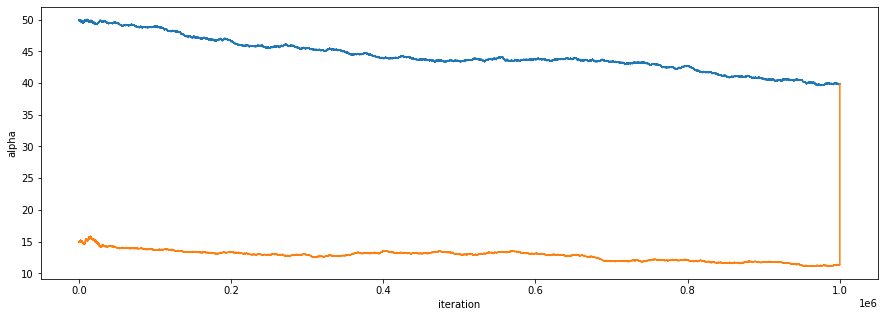

In [1014]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'alpha', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'alpha', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

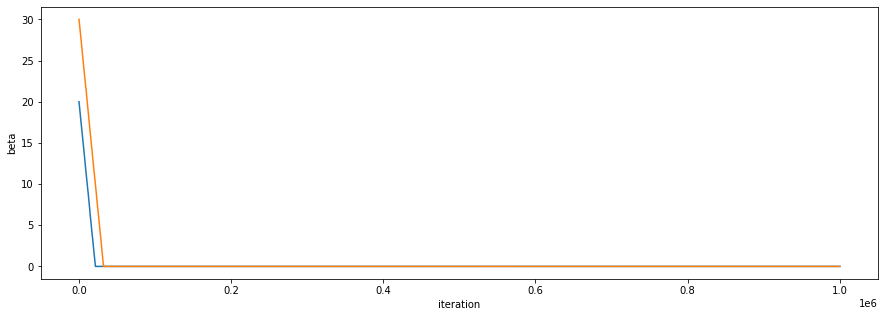

In [1015]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'beta', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'beta', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

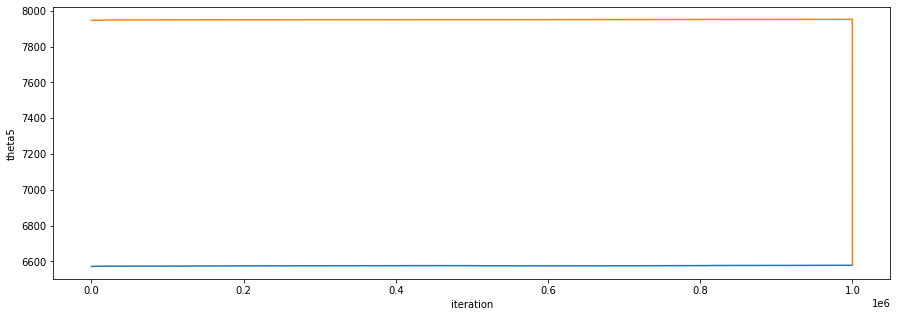

In [1016]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'theta5', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'theta5', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

### Metropolis within Gibbs

In [173]:
y = data2.iloc[2, 2:12].astype(int).to_numpy() + data2.iloc[2, 12:22].astype(int).to_numpy()

In [174]:
data = y

a_1 = 50
b_1 = 20
theta_1 = np.random.gamma(50 + y, 21, len(y))

a_2 = 15
b_2 = 30
theta_2 = np.random.gamma(15 + y, 31, len(y))

x_init = np.append([a_1, b_1], theta_1)
y_init = np.append([a_2, b_2], theta_2)

params, mu, tuning, c, iteration, rate = adaptive_metro2(data, y_init, log_pg)



100000


In [175]:
chain_df = pd.DataFrame(params, columns = ['alpha', 'beta', 'theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8', 'theta9', 'theta10'])
chain_df = chain_df.reset_index().rename(columns = {'index': 'iteration'})

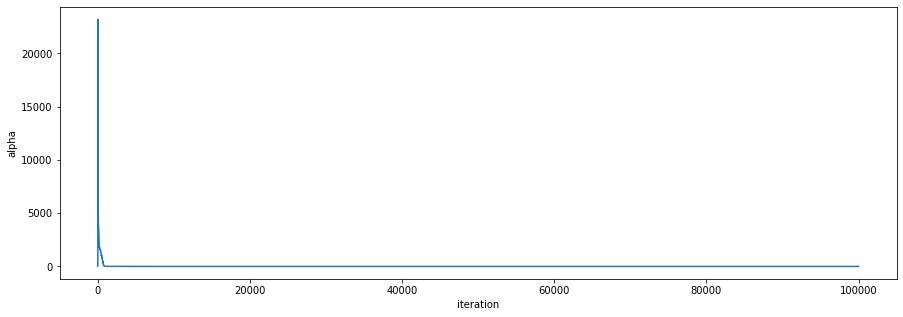

In [176]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain_df, x = 'iteration', y = 'alpha', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

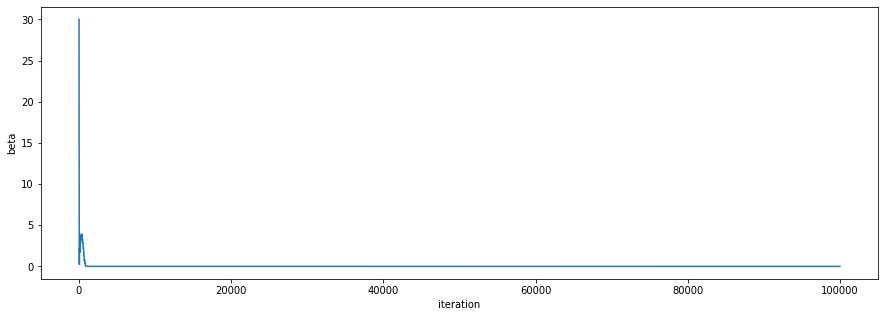

In [177]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain_df, x = 'iteration', y = 'beta', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

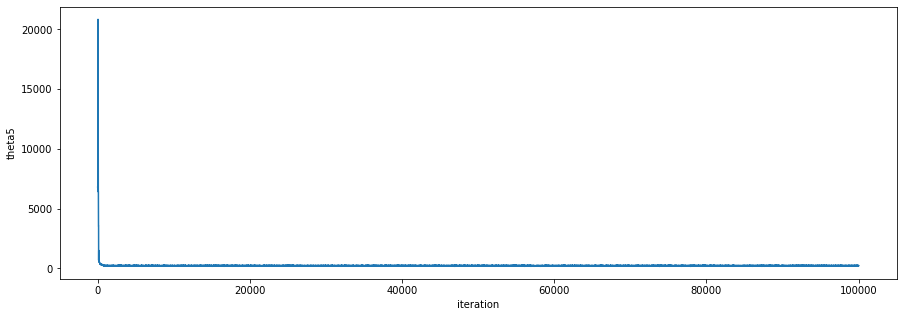

In [178]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain_df, x = 'iteration', y = 'theta5', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

In [182]:
data = y

a_1 = 50
b_1 = 20
theta_1 = np.random.gamma(50 + y, 21, len(y))

a_2 = 15
b_2 = 30
theta_2 = np.random.gamma(15 + y, 31, len(y))

x_init = np.append([a_1, b_1], theta_1)
y_init = np.append([a_2, b_2], theta_2)

lamb = tuning[-1] + 0.01

params_x, params_y, iteration = coupled_metropolis2(data, x_init, y_init, equality, log_pg, tuning = np.sqrt(np.exp(2 * c[-1]) * lamb))

7599


In [183]:
chain1_df = pd.DataFrame(params_x, columns = ['alpha', 'beta', 'theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8', 'theta9', 'theta10'])
chain2_df = pd.DataFrame(params_y, columns = ['alpha', 'beta', 'theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8', 'theta9', 'theta10'])
chain1_df = chain1_df.reset_index().rename(columns = {'index': 'iteration'})
chain2_df = chain2_df.reset_index().rename(columns = {'index': 'iteration'})

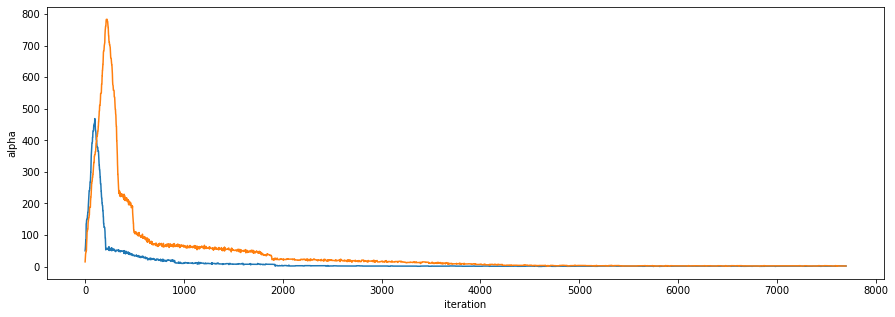

In [184]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'alpha', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'alpha', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

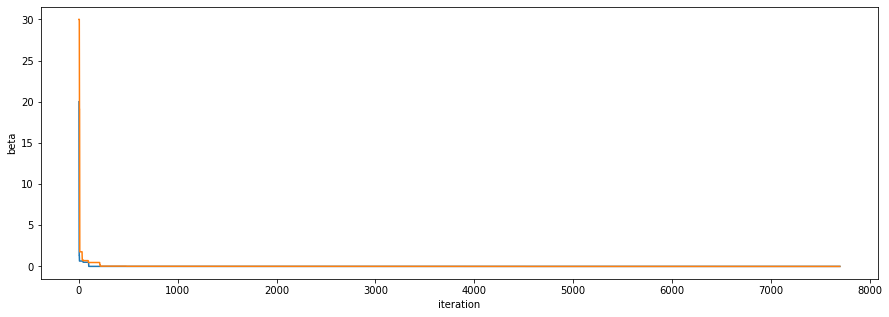

In [185]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'beta', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'beta', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

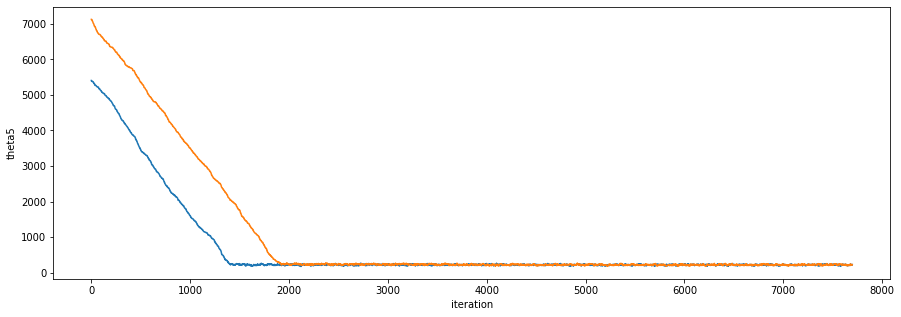

In [186]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'theta5', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'theta5', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

### Gibbs

In [366]:
y = data2.iloc[2, 2:12].astype(int).to_numpy() + data2.iloc[2, 12:22].astype(int).to_numpy()
data = [y]

a_1 = 50
b_1 = 20
theta_1 = np.random.gamma(50 + y, 21, len(y))

a_2 = 15
b_2 = 30
theta_2 = np.random.gamma(15 + y, 31, len(y))

x_init = np.array((np.array([b_1]), np.array(theta_1), np.array([a_1])), dtype = 'object')
y_init = np.array((np.array([b_2]), np.array(theta_2), np.array([a_2])), dtype = 'object')

beta = lambda data, params: np.array([np.random.gamma(10 * params[-1][0] + 1, scale = 1 / (np.sum(params[1])))])
thetas = lambda data, params: np.random.gamma(params[-1][0] + data[0], scale = 1 / (params[0][0] + 1), size = 10)
gibbs_vec = [beta, thetas]

params, mu, tuning, c, iteration, rate = adaptive_gibbs(data, x_init, log_a, gibbs_vec)


100000


In [367]:
lamb = tuning + 0.01

params_x, params_y, iteration = coupled_metropolis_gibbs(data, x_init, y_init, equality, log_a, tuning = np.exp(2 * c) * lamb, gibbs_vec = gibbs_vec, k = 1000)


104


In [369]:
chain1_df = pd.DataFrame([np.hstack(x) for x in params_x], columns = ['beta', 'theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8', 'theta9', 'theta10', 'alpha'])
chain2_df = pd.DataFrame([np.hstack(y) for y in params_y], columns = ['beta', 'theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8', 'theta9', 'theta10', 'alpha'])
chain1_df = chain1_df.reset_index().rename(columns = {'index': 'iteration'})
chain2_df = chain2_df.reset_index().rename(columns = {'index': 'iteration'})


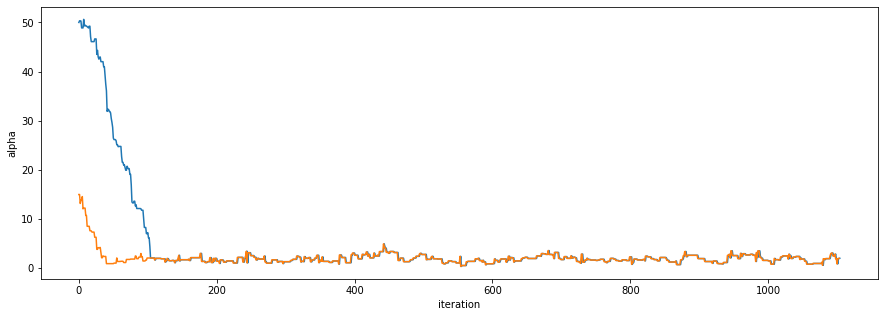

In [370]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'alpha', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'alpha', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

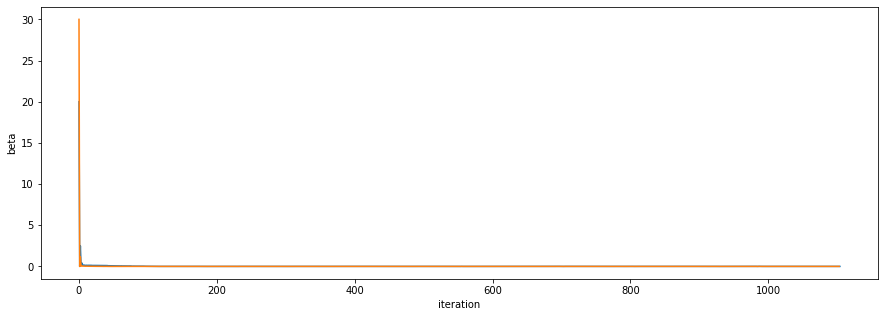

In [371]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'beta', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'beta', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

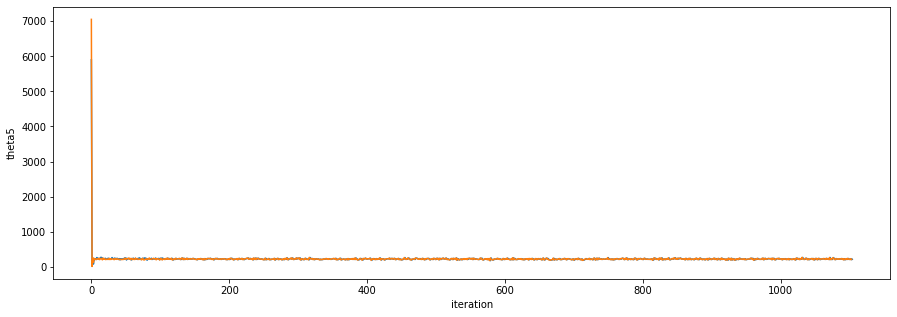

In [372]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'theta5', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'theta5', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

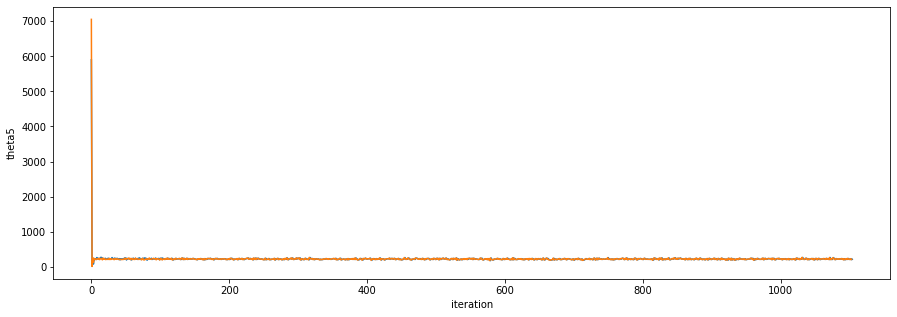

In [373]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'theta5', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'theta5', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

# Combined Adaptive MCMC

## Metropolis

In [ ]:
def coupled_adaptive_metropolis1(data, x_init, y_init, converge_fun, logpdf_fun, eps = 0.01, k = 100, lag = 1, maximum_iteration = 10000):
    params_x = [np.array(x_init)]
    params_y = [np.array(y_init)]

    mu_x = params_x[-1]
    Gamma_x = np.zeros((len(params_x[-1]), len(params_x[-1])))
    sigma_x = 0.7
    nx = 0
    gamma_x = 1


    mu_y = params_y[-1]
    Gamma_y = np.zeros((len(params_y[-1]), len(params_y[-1])))
    sigma_y = 0.7
    ny = 0
    gamma_y = 1
    
    iteration = 0
    
    logpdf = lambda z: logpdf_fun(data, z)
    
    while not converge_fun(params_x[-1], params_y[-1], Gamma_x, Gamma_y, sigma_x, sigma_y, eps, 1):
        if lag <= iteration:
            lamb_x = Gamma_x + eps * np.eye(len(Gamma_x))
            lamb_y = Gamma_y + eps * np.eye(len(Gamma_y))
            tuning_x = np.exp(2 * sigma_x) * lamb_x
            tuning_y = np.exp(2 * sigma_y) * lamb_y
            x_prop, y_prop = sample_couple_adaptive(params_x[-1], params_y[-1], tuning_x, tuning_y)
            log_u = np.log(random.uniform(0, 1))

            
            log_rx = min(0, logpdf(x_prop) - logpdf(params_x[-1]))
            log_ry = min(0, logpdf(y_prop) - logpdf(params_y[-1]))
    
            if log_u <= log_rx:
                params_x.append(x_prop)
            else:
                params_x.append(params_x[-1])
    
            if log_u <= log_ry:
                params_y.append(y_prop)
            else:
                params_y.append(params_y[-1])

            nx += 1
            ny += 1
            
            m_x = params_x[-1] - mu_x
            Gamma_x = Gamma_x + (np.matmul(np.atleast_2d(m_x).T, np.atleast_2d(m_x)) - Gamma_x) / nx
    
            mu_x = mu_x + (params_x[-1] - mu_x) / nx
    
            gamma_x = np.sqrt(1/nx)
            sigma_x = sigma_x + gamma_x * (np.exp(log_rx) - 0.3)

            m_y = params_y[-1] - mu_y
            Gamma_y = Gamma_y + (np.matmul(np.atleast_2d(m_y).T, np.atleast_2d(m_y)) - Gamma_y) / ny
    
            mu_y = mu_y + (params_y[-1] - mu_y) / ny
    
            gamma_y = np.sqrt(1/ny)
            sigma_y = sigma_y + gamma_y * (np.exp(log_ry) - 0.3)

    
        else:
            lamb_x = Gamma_x + eps * np.eye(len(Gamma_x))
            tuning_x = np.exp(2 * sigma_x) * lamb_x
            x_prop = scipy.stats.multivariate_normal.rvs(params_x[-1], tuning_x)
            log_u = np.log(random.uniform(0, 1))

            log_rx = min(0, logpdf(x_prop) - logpdf(params_x[-1]))
    
            if log_u <= log_rx:
                params_x.append(x_prop)
            else:
                params_x.append(params_x[-1])

            nx += 1
            
            m_x = params_x[-1] - mu_x
            Gamma_x = Gamma_x + (np.matmul(np.atleast_2d(m_x).T, np.atleast_2d(m_x)) - Gamma_x) / nx
    
            mu_x = mu_x + (params_x[-1] - mu_x) / nx
    
            gamma_x = np.sqrt(1/nx)
            sigma_x = sigma_x + gamma_x * (np.exp(log_rx) - 0.3)
                    
        iteration += 1
        
        if iteration == maximum_iteration:
            break
        
    print(iteration)

    if iteration != maximum_iteration:
        for i in range(k):
            lamb_x = Gamma_x + eps * np.eye(len(Gamma_x))
            tuning_x = np.exp(2 * sigma_x) * lamb_x
            x_prop = scipy.stats.multivariate_normal.rvs(params_x[-1], tuning_x)
            logu = np.log(random.uniform(0, 1))
            temp = ar(params_x[-1], x_prop, logu, logpdf)[0]
            params_x.append(temp)
            params_y.append(temp)
        
    return params_x, params_y, iteration
    

In [146]:
n = data1['n'].to_numpy()
y = data1['y'].to_numpy()
data = [y, n]

a_1 = 1
b_1 = 2
theta_1 = np.random.beta(y + a_1, n - y + b_1, 15)

a_2 = 20
b_2 = 50
theta_2 = np.random.beta(y + a_2, n - y + b_2, 15)

x_init = np.append([a_1, b_1], theta_1)
y_init = np.append([a_2, b_2], theta_2)

params_x, params_y, iteration = coupled_adaptive_metropolis1(data, x_init, y_init, adaptive_converge2, log_bb, k = 10000, maximum_iteration = 1000000)


1000000


In [147]:
chain1_df = pd.DataFrame(params_x, columns = ['alpha', 'beta', 'theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8', 'theta9', 'theta10', 'theta11', 'theta12', 'theta13', 'theta14', 'theta15'])
chain2_df = pd.DataFrame(params_y, columns = ['alpha', 'beta', 'theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8', 'theta9', 'theta10', 'theta11', 'theta12', 'theta13', 'theta14', 'theta15'])
chain1_df = chain1_df.reset_index().rename(columns = {'index': 'iteration'})
chain2_df = chain2_df.reset_index().rename(columns = {'index': 'iteration'})

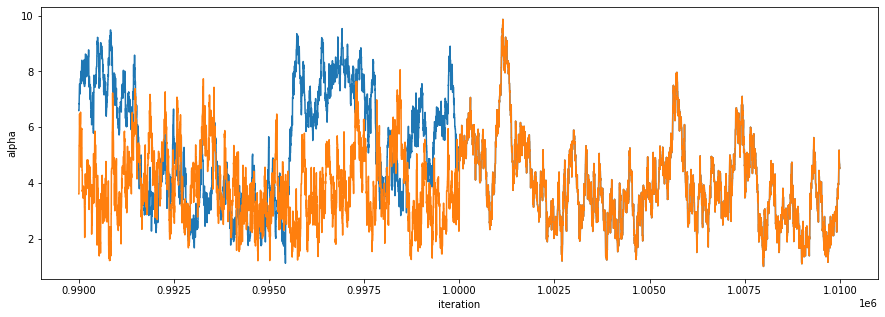

In [148]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df[-20000:], x = 'iteration', y = 'alpha', ax = ax)
sns.lineplot(data = chain2_df[-20000:], x = 'iteration', y = 'alpha', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

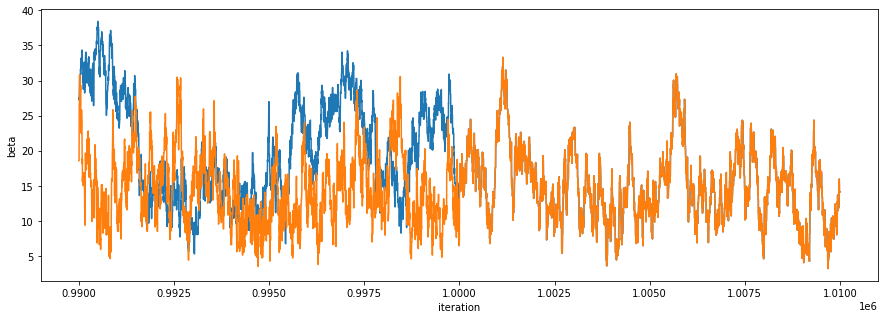

In [149]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df[-20000:], x = 'iteration', y = 'beta', ax = ax)
sns.lineplot(data = chain2_df[-20000:], x = 'iteration', y = 'beta', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

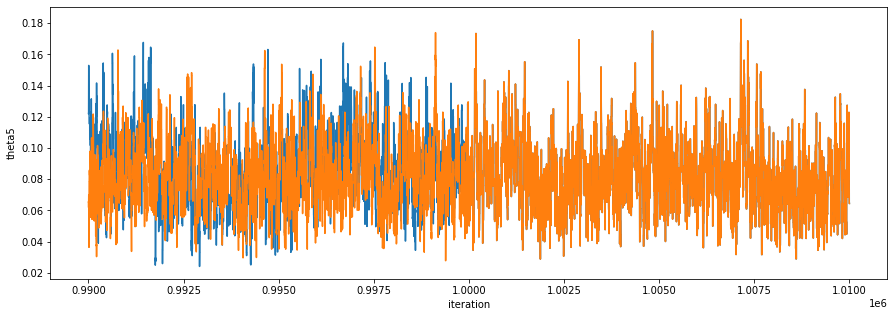

In [150]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df[-20000:], x = 'iteration', y = 'theta5', ax = ax)
sns.lineplot(data = chain2_df[-20000:], x = 'iteration', y = 'theta5', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

## Metropolis Gibbs

In [447]:
def coupled_adaptive_metropolis2(data, x_init, y_init, converge_fun, logpdf_fun, eps = 0.01, k = 100, lag = 1, maximum_iteration = 10000):
    params_x = [np.array(x_init)]
    params_y = [np.array(y_init)]

    mu_x = params_x[-1]
    Gamma_x = np.zeros(len(params_x[-1]))
    sigma_x = np.ones(len(params_x[-1])) * 0.7
    nx = 0
    gamma_x = 1


    mu_y = params_y[-1]
    Gamma_y = np.zeros(len(params_y[-1]))
    sigma_y = np.ones(len(params_y[-1])) * 0.7
    ny = 0
    gamma_y = 1
    
    iteration = 0
        
    while not converge_fun(params_x[-1], params_y[-1], Gamma_x, Gamma_y, sigma_x, sigma_y, eps, 0.05):
        if lag <= iteration:
            lamb_x = Gamma_x + eps
            lamb_y = Gamma_y + eps

            tuning_x = np.exp(2 * sigma_x) * lamb_x
            tuning_y = np.exp(2 * sigma_y) * lamb_y

            x_prop, y_prop = sample_couple_adaptive(params_x[-1], params_y[-1], tuning_x, tuning_y)

            log_rx = np.zeros(len(params_x[-1]))
            log_ry = np.zeros(len(params_y[-1]))

            for j in range(len(params_x[-1])):
                logpdf_x = lambda z: logpdf_fun(data, np.hstack((params_x[-1][:j], z, params_x[-1][j + 1:])))
                logpdf_y = lambda z: logpdf_fun(data, np.hstack((params_y[-1][:j], z, params_y[-1][j + 1:])))
    
                log_u = np.log(random.uniform(0, 1))
    
                log_rx[j] = min(0, logpdf_x(x_prop[j]) - logpdf_x(params_x[-1][j]))
                log_ry[j] = min(0, logpdf_y(y_prop[j]) - logpdf_y(params_y[-1][j]))
    
                if log_u <= log_rx[j]:
                    pass
                else:
                    x_prop[j] = params_x[-1][j]
    
                if log_u <= log_ry[j]:
                    pass
                else:
                    y_prop[j] = params_y[-1][j]

            params_x.append(x_prop)
            params_y.append(y_prop)
    
            nx += 1
            ny += 1
    
            mx = params_x[-1] - mu_x
            Gamma_x = Gamma_x + (np.power(mx, 2) - Gamma_x) / nx
            mu_x = mu_x + (params_x[-1] - mu_x) / nx
            gamma_x = np.sqrt(1/nx)
            sigma_x = sigma_x + gamma_x * (np.exp(log_rx) - 0.3)
    
            my = params_y[-1] - mu_y
            Gamma_y = Gamma_y + (np.power(my, 2) - Gamma_y) / ny
            mu_y = mu_y + (params_y[-1] - mu_y) / ny
            gamma_y = np.sqrt(1/ny)
            sigma_y = sigma_y + gamma_y * (np.exp(log_ry) - 0.3)

    
        else:
            lamb_x = Gamma_x + eps
            tuning_x = np.exp(2 * sigma_x) * lamb_x
            
            x_prop = scipy.stats.multivariate_normal.rvs(params_x[-1], tuning_x)

            log_rx = np.zeros(len(params_x[-1]))

            for j in range(len(params_x[-1])):
                logpdf_x = lambda z: logpdf_fun(data, np.hstack((params_x[-1][:j], z, params_x[-1][j + 1:])))
        
                log_u = np.log(random.uniform(0, 1))
    
                log_rx[j] = min(0, logpdf_x(x_prop[j]) - logpdf_x(params_x[-1][j]))
    
                if log_u <= log_rx[j]:
                    pass
                else:
                    x_prop[j] = params_x[-1][j]

            params_x.append(x_prop)
    
            nx += 1
    
            mx = params_x[-1] - mu_x
            Gamma_x = Gamma_x + (np.power(mx, 2) - Gamma_x) / nx
            mu_x = mu_x + (params_x[-1] - mu_x) / nx
            gamma_x = np.sqrt(1/nx)
            sigma_x = sigma_x + gamma_x * (np.exp(log_rx) - 0.3)
 
        iteration += 1
        
        if iteration == maximum_iteration:
            break
        
    print(iteration)
    
    if iteration != maximum_iteration:
        for i in range(k):
            lamb_x = Gamma_x + eps
            tuning_x = np.exp(2 * sigma_x) * lamb_x
            
            x_prop = scipy.stats.multivariate_normal.rvs(params_x[-1], tuning_x)

            log_rx = np.zeros(len(params_x[-1]))

            for j in range(len(params_x[-1])):
                logpdf_x = lambda z: logpdf_fun(data, np.hstack((params_x[-1][:j], z, params_x[-1][j + 1:])))
        
                log_u = np.log(random.uniform(0, 1))
    
                log_rx[j] = min(0, logpdf_x(x_prop[j]) - logpdf_x(params_x[-1][j]))
    
                if log_u <= log_rx[j]:
                    pass
                else:
                    x_prop[j] = params_x[-1][j]

            params_x.append(x_prop)
            params_y.append(x_prop)
        
    return params_x, params_y, Gamma_x, Gamma_y, sigma_x, sigma_y, iteration
    

In [448]:
n = data1['n'].to_numpy()
y = data1['y'].to_numpy()
data = [y, n]

a_1 = 1
b_1 = 2
theta_1 = np.random.beta(y + a_1, n - y + b_1, 15)

a_2 = 20
b_2 = 50
theta_2 = np.random.beta(y + a_2, n - y + b_2, 15)

x_init = np.append([a_1, b_1], theta_1)
y_init = np.append([a_2, b_2], theta_2)

params_x, params_y, Gamma_x, Gamma_y, sigma_x, sigma_y, iteration = coupled_adaptive_metropolis2(data, x_init, y_init, adaptive_converge, log_bb, k = 10000, maximum_iteration = 100000)


23146


In [451]:
chain1_df = pd.DataFrame(params_x, columns = ['alpha', 'beta', 'theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8', 'theta9', 'theta10', 'theta11', 'theta12', 'theta13', 'theta14', 'theta15'])
chain2_df = pd.DataFrame(params_y, columns = ['alpha', 'beta', 'theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8', 'theta9', 'theta10', 'theta11', 'theta12', 'theta13', 'theta14', 'theta15'])
chain1_df = chain1_df.reset_index().rename(columns = {'index': 'iteration'})
chain2_df = chain2_df.reset_index().rename(columns = {'index': 'iteration'})

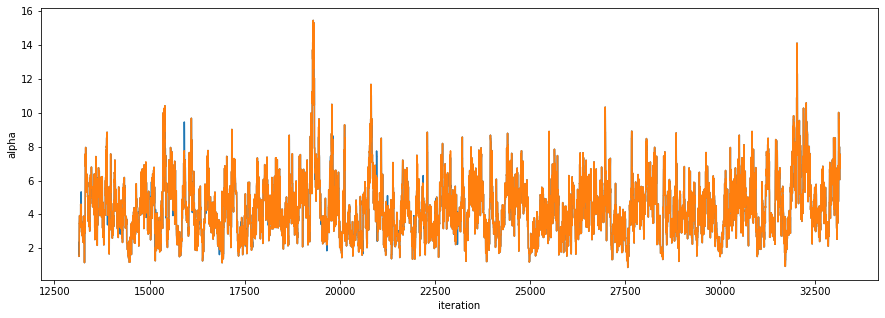

In [452]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df[-20000:], x = 'iteration', y = 'alpha', ax = ax)
sns.lineplot(data = chain2_df[-20000:], x = 'iteration', y = 'alpha', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

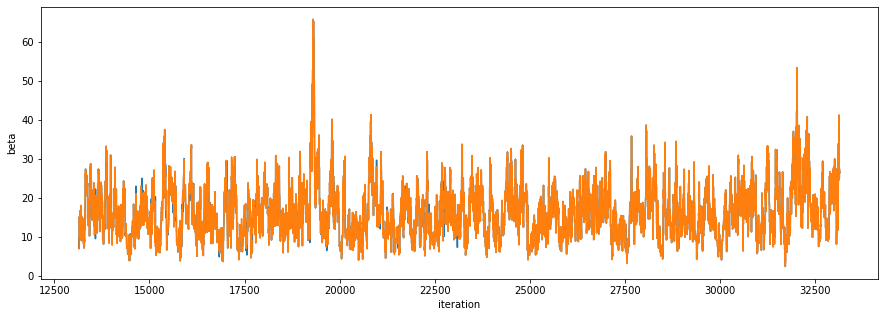

In [453]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df[-20000:], x = 'iteration', y = 'beta', ax = ax)
sns.lineplot(data = chain2_df[-20000:], x = 'iteration', y = 'beta', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

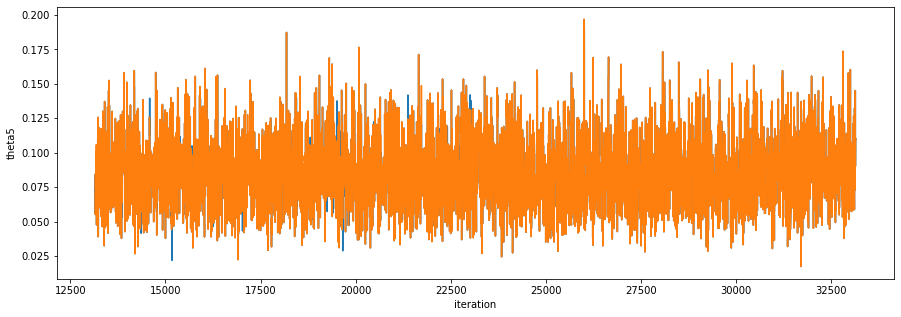

In [454]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df[-20000:], x = 'iteration', y = 'theta5', ax = ax)
sns.lineplot(data = chain2_df[-20000:], x = 'iteration', y = 'theta5', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

## Gibbs

In [527]:
def coupled_adaptive_gibbs(data, x_init, y_init, converge_fun, logpdf_fun, gibbs_vec, eps = 0.01, k = 100, lag = 1, maximum_iteration = 10000):
    params_x = [x_init]
    params_y = [y_init]

    mu_x = params_x[-1][-1]
    Gamma_x = np.zeros(len(params_x[-1][-1]))
    sigma_x = np.ones(len(params_x[-1][-1])) * 0.7
    nx = 0
    gamma_x = 1


    mu_y = params_y[-1][-1]
    Gamma_y = np.zeros(len(params_y[-1][-1]))
    sigma_y = np.ones(len(params_y[-1][-1])) * 0.7
    ny = 0
    gamma_y = 1
    
    iteration = 0

    while not converge_fun(params_x[-1][-1], params_y[-1][-1], Gamma_x, Gamma_y, sigma_x, sigma_y, eps, 0.05):
        if lag <= iteration:
            temp_x = np.zeros(len(x_init), dtype = 'object')
            temp_y = np.zeros(len(y_init), dtype = 'object')

            # print("first")
            # print(params_x[-1])

            for j in range(len(gibbs_vec)):
                # print("next")
                # print(params_x[-1])
                temp_x[j] = gibbs_vec[j](data, params_x[-1])
                temp_y[j] = gibbs_vec[j](data, params_y[-1])

            lamb_x = Gamma_x + eps
            lamb_y = Gamma_y + eps

            tuning_x = np.exp(2 * sigma_x) * lamb_x
            tuning_y = np.exp(2 * sigma_y) * lamb_y

            x_prop, y_prop = sample_couple_adaptive(params_x[-1][-1], params_y[-1][-1], tuning_x, tuning_y)
            log_rx = np.zeros(len(params_x[-1][-1]))
            log_ry = np.zeros(len(params_y[-1][-1]))
            
            for j in range(len(x_prop)):
                logpdf_x = lambda z: logpdf_fun(data, np.array(list(params_x[-1][:-1]) + [np.hstack((params_x[-1][-1][:j], z, params_x[-1][-1][(j + 1):]))], dtype = 'object'))
                logpdf_y = lambda z: logpdf_fun(data, np.array(list(params_y[-1][:-1]) + [np.hstack((params_y[-1][-1][:j], z, params_y[-1][-1][(j + 1):]))], dtype = 'object'))

                log_u = np.log(random.uniform(0, 1))
                
                log_rx[j] = min(0, logpdf_x(x_prop[j]) - logpdf_x(params_x[-1][-1][j]))
                log_ry[j] = min(0, logpdf_y(y_prop[j]) - logpdf_y(params_y[-1][-1][j]))

                if log_u <= log_rx[j]:
                    pass
                else:
                    x_prop[j] = params_x[-1][-1][j]
    
                if log_u <= log_ry[j]:
                    pass
                else:
                    y_prop[j] = params_y[-1][-1][j]
            
            temp_x[-1] = x_prop
            temp_y[-1] = y_prop
    
            params_x.append(temp_x)
            params_y.append(temp_y)
            
            nx += 1
            mx = params_x[-1][-1] - mu_x
            Gamma_x = Gamma_x + (np.power(mx, 2) - Gamma_x) / nx
            mu_x = mu_x + (params_x[-1][-1] - mu_x)/nx
            gamma_x = np.sqrt(1/nx)
            sigma_x = sigma_x + gamma_x * (np.exp(log_rx) - 0.3)

            ny += 1
            my = params_y[-1][-1] - mu_y
            Gamma_y = Gamma_y + (np.power(my, 2) - Gamma_y) / ny
            mu_y = mu_y + (params_y[-1][-1] - mu_y)/ny
            gamma_y = np.sqrt(1/ny)
            sigma_y = sigma_y + gamma_y * (np.exp(log_ry) - 0.3)
        
        else:
            temp_x = np.zeros(len(x_init), dtype = 'object')

            for j in range(len(gibbs_vec)):
                temp_x[j] = gibbs_vec[j](data, params_x[-1])

            lamb_x = Gamma_x + eps
            tuning_x = np.exp(2 * sigma_x) * lamb_x
            x_prop = np.array([scipy.stats.multivariate_normal.rvs(params_x[-1][-1], tuning_x * np.ones(len(params_x[-1][-1])))]).ravel()
            log_rx = np.zeros(len(params_x[-1][-1]))
            
            for j in range(len(x_prop)):
                logpdf_x = lambda z: logpdf_fun(data, np.array(list(params_x[-1][:-1]) + [np.hstack((params_x[-1][-1][:j], z, params_x[-1][-1][(j + 1):]))], dtype = 'object'))
                log_u = np.log(random.uniform(0, 1))
                log_rx[j] = min(0, logpdf_x(x_prop[j]) - logpdf_x(params_x[-1][-1][j]))

                if log_u <= log_rx[j]:
                    pass
                else:
                    x_prop[j] = params_x[-1][-1][j]

            temp_x[-1] = x_prop
            params_x.append(temp_x)
            
            nx += 1
            mx = params_x[-1][-1] - mu_x
            Gamma_x = Gamma_x + (np.power(mx, 2) - Gamma_x) / nx
            mu_x = mu_x + (params_x[-1][-1] - mu_x)/nx
            gamma_x = np.sqrt(1/nx)
            sigma_x = sigma_x + gamma_x * (np.exp(log_rx) - 0.3)

        iteration += 1
        
        if iteration == maximum_iteration:
            break
        
    print(iteration)

    if iteration != maximum_iteration:
        for i in range(k):
            temp_x = np.zeros(len(x_init), dtype = 'object')

            for j in range(len(gibbs_vec)):
                temp_x[j] = gibbs_vec[j](data, params_x[-1])

            lamb_x = Gamma_x + eps
            tuning_x = np.exp(2 * sigma_x) * lamb_x
            x_prop = np.array([scipy.stats.multivariate_normal.rvs(params_x[-1][-1], tuning_x * np.ones(len(params_x[-1][-1])))]).ravel()
            log_rx = np.zeros(len(params_x[-1][-1]))
            
            for j in range(len(x_prop)):
                logpdf_x = lambda z: logpdf_fun(data, np.array(list(params_x[-1][:-1]) + [np.hstack((params_x[-1][-1][:j], z, params_x[-1][-1][(j + 1):]))], dtype = 'object'))
                log_u = np.log(random.uniform(0, 1))
                log_rx[j] = min(0, logpdf_x(x_prop[j]) - logpdf_x(params_x[-1][-1][j]))

                if log_u <= log_rx[j]:
                    pass
                else:
                    x_prop[j] = params_x[-1][-1][j]

            temp_x[-1] = x_prop
            params_x.append(temp_x)
            params_y.append(temp_x)

    return params_x, params_y, Gamma_x, Gamma_y, sigma_x, sigma_y, iteration
        

In [538]:
#SUSPICIOUS WHETHER THIS IS WORKING OR NOT



n = data1['n'].to_numpy()
y = data1['y'].to_numpy()
data = [y, n]

a_1 = 1
b_1 = 2
theta_1 = np.random.beta(y + a_1, n - y + b_1, 15)

a_2 = 20
b_2 = 50
theta_2 = np.random.beta(y + a_2, n - y + b_2, 15)

x_init = np.array((np.array(theta_1), np.array([a_1, b_1])), dtype = 'object')
y_init = np.array((np.array(theta_2), np.array([a_2, b_2])), dtype = 'object')

thetas = lambda data, params: np.random.beta(data[0] + params[-1][0], data[1] - data[0] + params[-1][1], 15)
gibbs_vec = [thetas]

params_x, params_y, Gamma_x, Gamma_y, sigma_x, sigma_y, iteration = coupled_adaptive_gibbs(data, x_init, y_init, adaptive_converge, log_ab, gibbs_vec, k = 10000, maximum_iteration = 100000)


2866


In [539]:
chain1_df = pd.DataFrame([np.hstack(x) for x in params_x], columns = ['theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8', 'theta9', 'theta10', 'theta11', 'theta12', 'theta13', 'theta14', 'theta15', 'alpha', 'beta'])
chain2_df = pd.DataFrame([np.hstack(y) for y in params_y], columns = ['theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8', 'theta9', 'theta10', 'theta11', 'theta12', 'theta13', 'theta14', 'theta15', 'alpha', 'beta'])

chain1_df = chain1_df.reset_index().rename(columns = {'index': 'iteration'})
chain2_df = chain2_df.reset_index().rename(columns = {'index': 'iteration'})


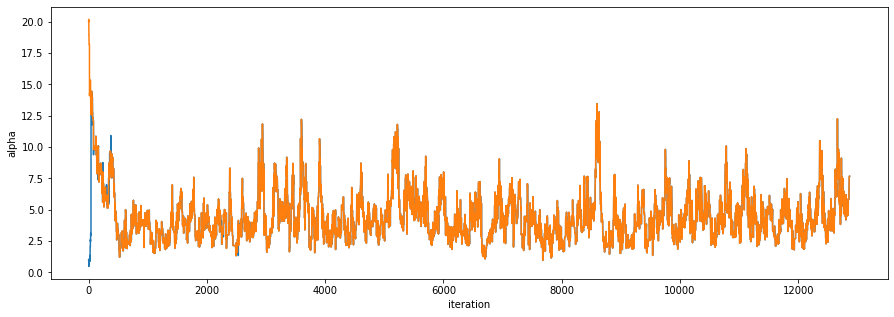

In [540]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df[-20000:], x = 'iteration', y = 'alpha', ax = ax)
sns.lineplot(data = chain2_df[-20000:], x = 'iteration', y = 'alpha', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

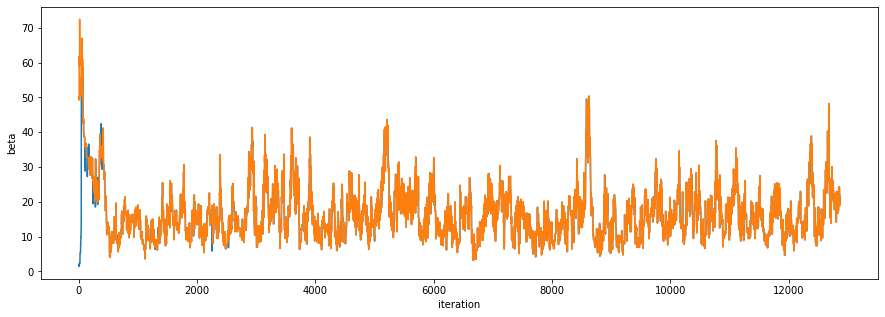

In [541]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df[-20000:], x = 'iteration', y = 'beta', ax = ax)
sns.lineplot(data = chain2_df[-20000:], x = 'iteration', y = 'beta', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

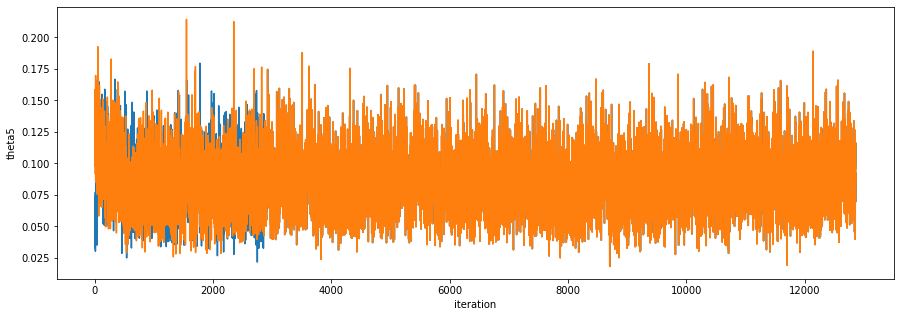

In [542]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df[-20000:], x = 'iteration', y = 'theta5', ax = ax)
sns.lineplot(data = chain2_df[-20000:], x = 'iteration', y = 'theta5', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

# Logistic Regression

$$p(y, x | \theta) = \prod_{i = 1}^n p_i(\theta)^{y_i}(1 - p_i(\theta))^{1 - y_i} = $$

$$\prod_{i = 1}^n \frac{e^{y_i\langle x_i, \theta\rangle}}{(1 + e^{\langle x_i, \theta\rangle})^{y_i}} \cdot \frac{1}{(1 + e^{\langle x_i, \theta\rangle})^{1 - y_i}} = $$

$$\prod_{i = 1}^n \frac{e^{y_i\langle x_i, \theta\rangle}}{1 + e^{\langle x_i, \theta\rangle}}$$


## Model \#1

$$p(\theta_i) \propto 1$$

$$p(\theta | y, x) = p(y, x | \theta) \propto \prod_{i = 1}^n \frac{e^{y_i\langle x_i, \theta\rangle}}{1 + e^{\langle x_i, \theta\rangle}} = \prod_{i = 1}^n \frac{e^{y_i x_i\theta}}{1 + e^{x_i\theta}} \Rightarrow $$

$$logp(\theta | y, x) \propto \sum_{i = 1}^n y_i x_i\theta - \ln(1 + e^{x_i\theta})$$

In [554]:
def log_reg1(data, params):
    return np.sum(np.dot((data[0] * data[1].T).T, params) - np.log(1 + np.exp(np.dot(data[1], params))))



In [18]:
def log_reg1_test(data, params):
    return np.sum(np.dot((data[0] * data[1].T).T, params) - np.dot(data[1], params))



In [555]:
# generate test data

temp = np.random.uniform(0, 1, size = 100)
x = temp.reshape(10, 10)
y = np.zeros(len(x))
for i in range(len(x)):
    if all(x[i] > 0.08):
        y[i] = 1
    else:
        y[i] = 0

In [570]:
data = [y, x]

theta_1 = np.ones(len(x[0])) * -10

theta_2 = np.ones(len(x[0])) * 10

x_init = theta_1
y_init = theta_2

params_x, params_y, iteration = coupled_metropolis1(data, x_init, y_init, log_reg1, tuning = 10 * np.eye(len(x_init)))



/var/folders/2d/9lmch7n90nb_zw70r3zdp0200000gn/T/ipykernel_1587/2432081925.py:2: RuntimeWarning: overflow encountered in exp
  return np.sum(np.dot((data[0] * data[1].T).T, params) - np.log(1 + np.exp(np.dot(data[1], params))))


100000


In [571]:
chain1_df = pd.DataFrame(params_x, columns = ['theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8', 'theta9', 'theta10'])
chain2_df = pd.DataFrame(params_y, columns = ['theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8', 'theta9', 'theta10'])
chain1_df = chain1_df.reset_index().rename(columns = {'index': 'iteration'})
chain2_df = chain2_df.reset_index().rename(columns = {'index': 'iteration'})

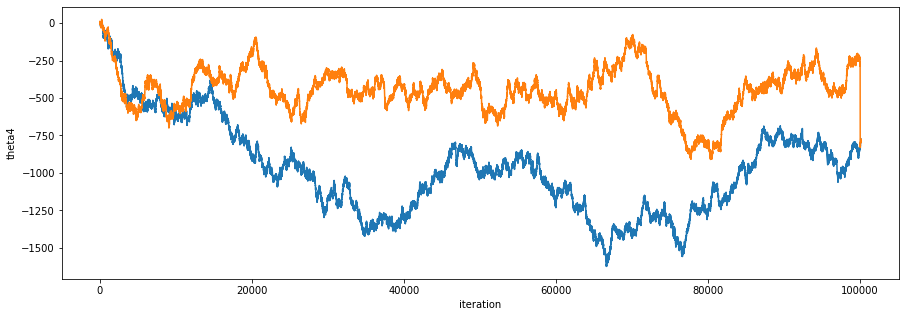

In [572]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'theta4', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'theta4', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

In [566]:
data = [y, x]

theta_1 = np.ones(len(x[0])) * -10

theta_2 = np.ones(len(x[0])) * 10

x_init = theta_1
y_init = theta_2

params, mu, tuning, c, iteration, rate = adaptive_metro1(data, x_init, log_reg1, eps = 25)


937


/var/folders/2d/9lmch7n90nb_zw70r3zdp0200000gn/T/ipykernel_1587/1243131108.py:29: RuntimeWarning: covariance is not positive-semidefinite.
  prop = np.random.multivariate_normal(mean = params[-1], cov = np.sqrt(np.exp(2 * sigma[-1]) * lamb))


In [567]:
data = [y, x]

theta_1 = np.ones(len(x[0])) * -10

theta_2 = np.ones(len(x[0])) * 10

x_init = theta_1
y_init = theta_2

lamb = tuning[-1] + 100 * np.eye(len(tuning[-1]))

params_x, params_y, iteration = coupled_metropolis1(data, x_init, y_init, log_reg1, tuning = np.sqrt(np.exp(2 * c[-1]) * lamb))

/var/folders/2d/9lmch7n90nb_zw70r3zdp0200000gn/T/ipykernel_1587/2432081925.py:2: RuntimeWarning: overflow encountered in exp
  return np.sum(np.dot((data[0] * data[1].T).T, params) - np.log(1 + np.exp(np.dot(data[1], params))))


KeyboardInterrupt: 

In [568]:
tuning[-1]

array([[117.4643779 ,  35.31569789,  25.01952304,  56.10681077,
         39.52673485,  56.62852553,  30.51382667,  25.        ,
         25.        ,  68.11252848],
       [ 35.31569789,  47.82022712,  25.        ,  25.16952792,
         25.        ,  35.80653429,  56.23446415,  46.96997132,
         35.61018052,  25.        ],
       [ 25.01952304,  25.        ,  80.50016085,  25.        ,
         55.23984368,  25.        ,  53.86719382,  61.23078255,
        117.73641092,  25.        ],
       [ 56.10681077,  25.16952792,  25.        , 715.45943849,
         61.13743084,  58.6217126 ,  25.32242804,  25.048445  ,
         33.19265148, 197.49630623],
       [ 39.52673485,  25.        ,  55.23984368,  61.13743084,
         87.0799194 ,  25.        ,  25.        ,  36.28751159,
         65.43849599,  25.09309182],
       [ 56.62852553,  35.80653429,  25.        ,  58.6217126 ,
         25.        ,  79.61623541,  26.4170802 ,  25.0613544 ,
         33.11611999,  53.79841967],
       [ 3

## Model \#2

$$\theta_i \sim N(\gamma_i, \tau^2)$$

$$p(\theta, \gamma, \tau^2 | y, x) = p(y, x | \theta) p(\theta)\propto \prod_{i = 1}^n \frac{e^{y_i x_i\theta_i}}{1 + e^{x_i\theta_i}} \cdot e^{\frac{1}{2\tau^2}\sum_{i = 1}^n(\theta_i - \gamma_i)^2} \Rightarrow$$

$$logp(\theta, \gamma, \tau^2 | y, x) = \sum_{i = 1}^n y_i x_i\theta_i - \ln(1 + e^{x_i\theta_i}) + \frac{1}{2\tau^2}\sum_{i = 1}^n(\theta_i - \gamma_i)^2$$

In [13]:
def log_reg2(data, params):
    return np.sum(data[0] * data[1] * params[0] - np.log(1 + np.exp(data[1] * params[0]))) + np.sum(np.power(params[0] - params[1], 2))/(2 * np.power(params[2], 2))                                                                                                 

In [122]:
y

array([0., 1., 0., 0., 0., 0., 0., 1., 1., 0.])

In [ ]:
def log_irt(data, params):
    -1/2 * np.matmul(np.atleast2d(params[0]).T, np.atleast2d(params[0]))

    

In [ ]:
implement reflection coupling ****

In [ ]:
clarify tuning params

# Different Coupling Method

In [590]:
def sample_couple2(prev_x, prev_y, tuning):
    log_p = lambda z: scipy.stats.multivariate_normal.logpdf(z, np.zeros(len(prev_x)), np.eye(len(tuning)))

    Delta = 1 / np.sqrt(tuning) * (prev_x - prev_y)
    e = Delta / np.sqrt(np.sum(np.power(Delta, 2)))

    x_dot = np.array([scipy.stats.multivariate_normal.rvs(np.zeros(len(prev_x)), np.eye(len(prev_x)))]).ravel()
    if np.log(random.uniform(0, 1)) <= log_p(x_dot + Delta) - log_p(x_dot):
        y_dot = x_dot + Delta
        return np.matmul(1 / np.sqrt(tuning), np.atleast_2d(x_dot).T) + prev_x, np.matmul(1 / np.sqrt(tuning), np.atleast_2d(y_dot).T) + prev_y
    else:
        y_dot = x_dot - 2 * np.matmul(np.matmul(np.atleast_2d(e).T, np.atleast_2d(x_dot)), np.atleast_2d(e).T).T.ravel()
        return np.matmul(1 / np.sqrt(tuning), np.atleast_2d(x_dot).T) + prev_x, np.matmul(1 / np.sqrt(tuning), np.atleast_2d(y_dot).T) + prev_y



In [591]:
def coupled_metropolis2(data, x_init, y_init, converge_fun, logpdf_fun, tuning, k = 100, lag = 1, maximum_iteration = 10000):
    params_x = [np.array(x_init)]
    params_y = [np.array(y_init)]
    
    iteration = 0
    
    while not converge_fun(params_x[-1], params_y[-1]):
        if lag <= iteration:
            x_prop, y_prop = sample_couple2(params_x[-1], params_y[-1], tuning)

            for j in range(len(x_prop)):
                logu = np.log(random.uniform(0, 1))
                x_prop[j] = ar(params_x[-1][j], x_prop[j], logu, lambda z: logpdf_fun(data, np.hstack((params_x[-1][:j], z, params_x[-1][j + 1:]))))[0]
                y_prop[j] = ar(params_y[-1][j], y_prop[j], logu, lambda z: logpdf_fun(data, np.hstack((params_y[-1][:j], z, params_y[-1][j + 1:]))))[0]
            
            params_x.append(x_prop)
            params_y.append(y_prop)

        else:
            x_prop = scipy.stats.multivariate_normal.rvs(params_x[-1], tuning * np.ones(len(params_x[-1])))
            
            for j in range(len(x_prop)):
                logu = np.log(random.uniform(0, 1))
                x_prop[j] = ar(params_x[-1][j], x_prop[j], logu, lambda z: logpdf_fun(data, np.hstack((params_x[-1][:j], z, params_x[-1][j + 1:]))))[0]

            params_x.append(x_prop)
            
        iteration += 1
        if iteration == maximum_iteration:
            break
        
    print(iteration)

    if iteration != maximum_iteration:
        for i in range(k):
            x_prop = scipy.stats.multivariate_normal.rvs(params_x[-1], tuning * np.ones(len(params_x[-1])))
            for j in range(len(x_prop)):
                logu = np.log(random.uniform(0, 1))
                x_prop[j] = ar(params_x[-1][j], x_prop[j], logu, lambda z: logpdf_fun(data, np.hstack((params_x[-1][:j], z, params_x[-1][j + 1:]))))[0]
    
            params_x.append(x_prop)
            params_y.append(x_prop)
        
    return params_x, params_y, iteration
    

In [592]:
n = data1['n'].to_numpy()
y = data1['y'].to_numpy()
data = [y, n]

a_1 = 1
b_1 = 2
theta_1 = np.random.beta(y + a_1, n - y + b_1, 15)

a_2 = 20
b_2 = 50
theta_2 = np.random.beta(y + a_2, n - y + b_2, 15)

x_init = np.append([a_1, b_1], theta_1)
y_init = np.append([a_2, b_2], theta_2)

params_x, params_y, iteration = coupled_metropolis2(data, x_init, y_init, equality, log_bb, tuning = np.array([0.3, 1.1] + [0.01] * 15), k = 1000)

10000


In [593]:
chain1_df = pd.DataFrame(params_x, columns = ['alpha', 'beta', 'theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8', 'theta9', 'theta10', 'theta11', 'theta12', 'theta13', 'theta14', 'theta15'])
chain2_df = pd.DataFrame(params_y, columns = ['alpha', 'beta', 'theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8', 'theta9', 'theta10', 'theta11', 'theta12', 'theta13', 'theta14', 'theta15'])
chain1_df = chain1_df.reset_index().rename(columns = {'index': 'iteration'})
chain2_df = chain2_df.reset_index().rename(columns = {'index': 'iteration'})

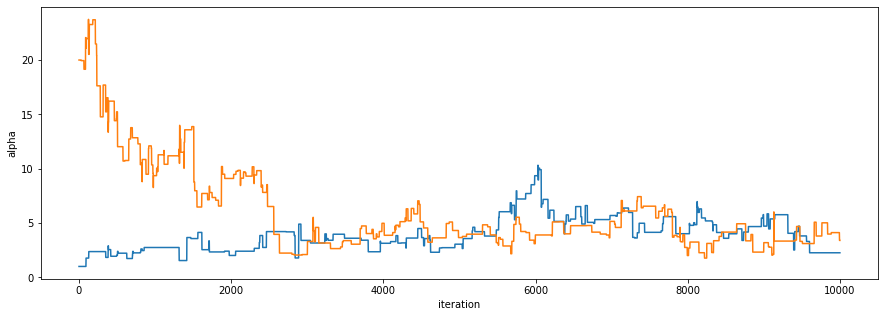

In [594]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'alpha', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'alpha', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

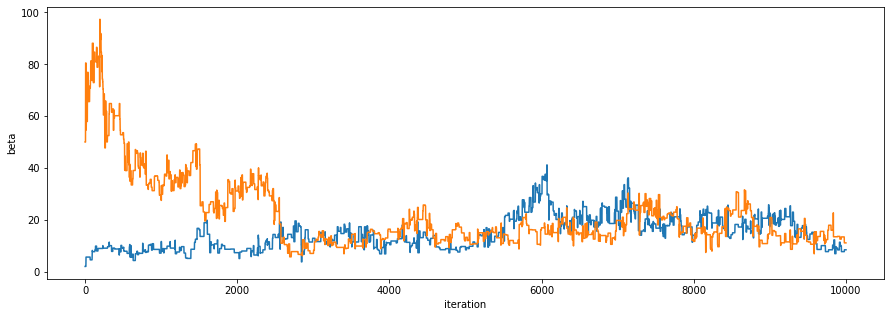

In [595]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'beta', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'beta', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

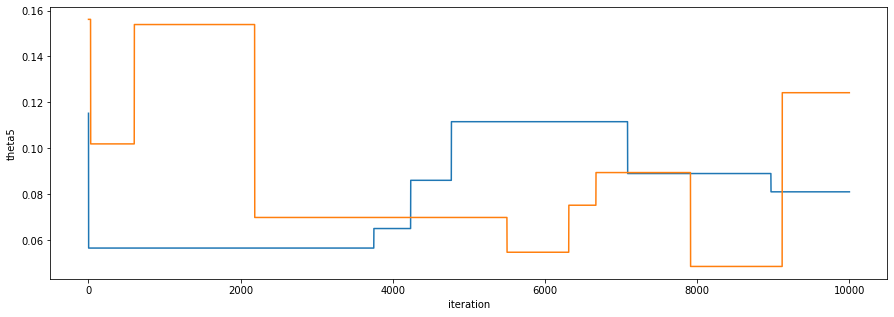

In [596]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'theta5', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'theta5', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

In [599]:
def coupled_metropolis_gibbs(data, x_init, y_init, converge_fun, logpdf_fun, tuning, gibbs_vec, k = 100, lag = 1, maximum_iteration = 10000):
    params_x = [x_init]
    params_y = [y_init]
    
    iteration = 0
    
    while not converge_fun(params_x[-1][-1], params_y[-1][-1]):
        if lag <= iteration:
            temp_x = np.zeros(len(x_init), dtype = 'object')
            temp_y = np.zeros(len(x_init), dtype = 'object')

            for j in range(len(gibbs_vec)):
                temp_x[j] = gibbs_vec[j](data, params_x[-1])
                temp_y[j] = gibbs_vec[j](data, params_y[-1])

            x_prop, y_prop = sample_couple2(params_x[-1][-1], params_y[-1][-1], tuning)

            for j in range(len(x_prop)):
                logu = np.log(random.uniform(0, 1))
                x_prop[j], a = ar(params_x[-1][-1][j], x_prop[j], logu, lambda z: logpdf_fun(data, np.array(list(params_x[-1][:-1]) + [np.hstack((params_x[-1][-1][:j], z, params_x[-1][-1][j + 1:]))], dtype = 'object')))
                y_prop[j], a = ar(params_y[-1][-1][j], y_prop[j], logu, lambda z: logpdf_fun(data, np.array(list(params_y[-1][:-1]) + [np.hstack((params_y[-1][-1][:j], z, params_y[-1][-1][j + 1:]))], dtype = 'object')))
            
            temp_x[-1] = x_prop
            temp_y[-1] = y_prop
            
            params_x.append(temp_x)
            params_y.append(temp_y)

        else:
            temp_x = np.zeros(len(x_init), dtype = 'object')
            for j in range(len(gibbs_vec)):
                temp_x[j] = gibbs_vec[j](data, params_x[-1])
            
            x_prop = np.array([scipy.stats.multivariate_normal.rvs(params_x[-1][-1], tuning * np.ones(len(params_x[-1][-1])))]).ravel()

            for j in range(len(x_prop)):
                logu = np.log(random.uniform(0, 1))                
                x_prop[j], a = ar(params_x[-1][-1][j], x_prop[j], logu, lambda z: logpdf_fun(data, np.array(list(params_x[-1][:-1]) + [np.hstack((params_x[-1][-1][:j], z, params_x[-1][-1][j + 1:]))], dtype = 'object')))
            
            temp_x[-1] = x_prop
            
            params_x.append(temp_x)            
            
        iteration += 1
        if iteration == maximum_iteration:
            break
        
    print(iteration)

    if iteration != maximum_iteration:
        for i in range(k):
            temp_x = np.zeros(len(x_init), dtype = 'object')
            for j in range(len(gibbs_vec)):
                temp_x[j] = gibbs_vec[j](data, params_x[-1])
                
            x_prop = np.array([scipy.stats.multivariate_normal.rvs(params_x[-1][-1], tuning * np.ones(len(params_x[-1][-1])))]).ravel()
    
            for j in range(len(x_prop)):
                logu = np.log(random.uniform(0, 1))
                x_prop[j], a = ar(params_x[-1][-1][j], x_prop[j], logu, lambda z: logpdf_fun(data, np.array(list(params_x[-1][:-1]) + [np.hstack((params_x[-1][-1][:j], z, params_x[-1][-1][j + 1:]))], dtype = 'object')))
    
            temp_x[-1] = x_prop
    
            params_x.append(temp_x)   
            params_y.append(temp_x)

    return params_x, params_y, iteration
    

In [600]:
n = data1['n'].to_numpy()
y = data1['y'].to_numpy()
data = [y, n]

a_1 = 1
b_1 = 2
theta_1 = np.random.beta(y + a_1, n - y + b_1, 15)

a_2 = 20
b_2 = 50
theta_2 = np.random.beta(y + a_2, n - y + b_2, 15)

x_init = np.array((np.array(theta_1), np.array([a_1, b_1])), dtype = 'object')
y_init = np.array((np.array(theta_2), np.array([a_2, b_2])), dtype = 'object')

thetas = lambda data, params: np.random.beta(data[0] + params[-1][0], data[1] - data[0] + params[-1][1], 15)
gibbs_vec = [thetas]

params_x, params_y, iteration = coupled_metropolis_gibbs(data, x_init, y_init, equality, log_ab, tuning = np.array([0.3, 1.1]), gibbs_vec = gibbs_vec, k = 1000)


10000


In [601]:
chain1_df = pd.DataFrame([np.hstack(x) for x in params_x], columns = ['theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8', 'theta9', 'theta10', 'theta11', 'theta12', 'theta13', 'theta14', 'theta15', 'alpha', 'beta'])
chain2_df = pd.DataFrame([np.hstack(y) for y in params_y], columns = ['theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8', 'theta9', 'theta10', 'theta11', 'theta12', 'theta13', 'theta14', 'theta15', 'alpha', 'beta'])
chain1_df = chain1_df.reset_index().rename(columns = {'index': 'iteration'})
chain2_df = chain2_df.reset_index().rename(columns = {'index': 'iteration'})

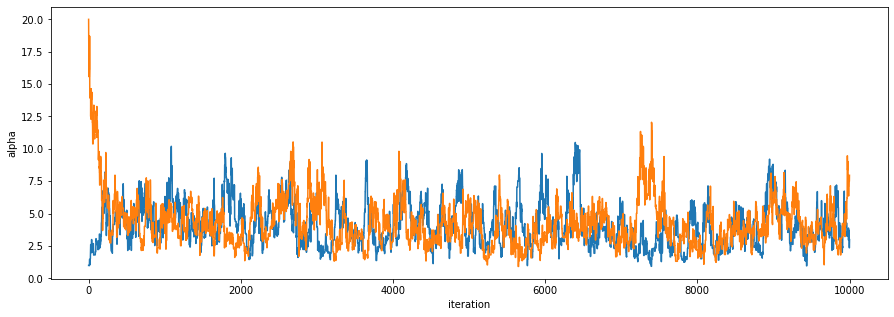

In [602]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'alpha', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'alpha', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

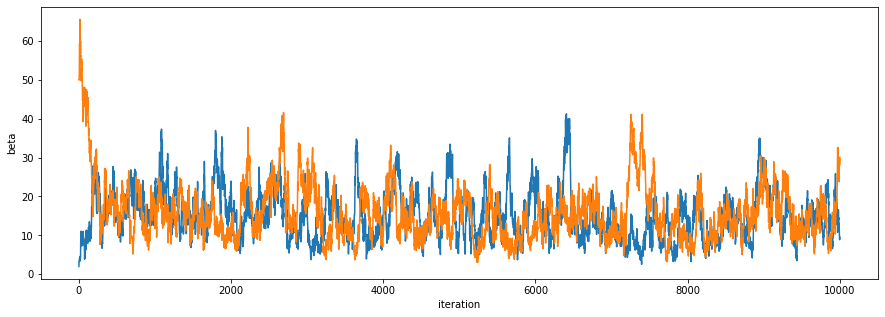

In [603]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'beta', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'beta', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

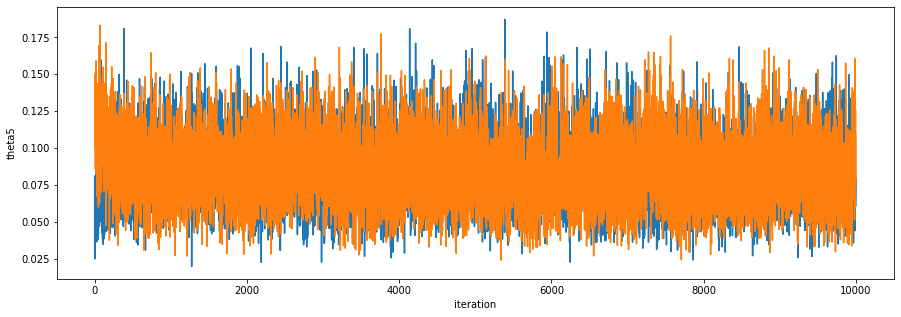

In [604]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'theta5', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'theta5', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()